# Import Libraries

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'carsforsale:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2354614%2F3967386%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T052023Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4308a5c8848526ea00397e1089e13ac06804b370030178a2fea0098a25215ee2bb81803c03d2a1cd88b618726caee7fa814429ad840bdec91f2bcff72e33d7e0fafd76145695a7577e3b4e7d5b0486914cdef165c06a6d803b64aa7d8b5847d43130a3e35c368e714b269208f50cb1cd7cf00fe6a63c7ba87ca27f3178d8de78a29f5f11512d6e944c1d29a3691129eaa5be25bda73bf40fc705fbcf1f6c806d40ad01cebd5e0d2ac9d99fbe80fd12bbfaf71712ad990136511148d0aaf83ed6470b50110e92d2475992c8a592dc57e149a8c8d801291c259c52bcb0a2bdfc90a64cc6bf5875c5cb7b4cbfb8c740ac6ce2e91b94b158c8f7513fd4666eb2d42e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 810173 bytes downloaded
Downloaded and uncompressed: carsforsale
Data source import complete.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression # LinearRegression algortimasını import ediyoruz.

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# modelimizin çıkan sonuçlarnı değerlendirmek için kullanılan görselleştirme kütüphaneleri

from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz
from yellowbrick.regressor import ResidualsPlot

from sklearn.tree import DecisionTreeRegressor


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carsforsale/cars_raw.csv


kullanılacak sütunlar:
- Year: Modelin yılı
- Make: araba'nın markası
- Model: arabanın modeli
- Used_New: ullanılıp kullanılmadığı
- Price(target): satıştaki fiyatı
- Consumer rating: arabaya gelen ortalama rate sayısı
- Consumer reviews: arbaaya gelen ortalama yorum sayısı
- seller type(categorik):dealer-private
- seller rating: satısıcının puanı
- seller review: satıcının aldığı yorumların ortalama
- deal type: satıcının pazarlığa olan davranışı
- ComfortRating	: arabanın rahatlığı
- InteriorDesignRating	: iç tasarımının değerlendirilmesi
- PerformanceRating: arabanın performansının değerlendirilmesi
- ValueForMoneyRating
- ExteriorStylingRating
- ReliabilityRating
- drive train: araç hareketinin nasıl sağlandığı ile ilgili
- fuel type
- MinMPG
- MaxMPG
- Engine
- transmission
- mileage

In [153]:
df= pd.read_csv("/kaggle/input/carsforsale/cars_raw.csv")

In [4]:
df.head()

Year    Make            Model Used/New    Price  ConsumerRating  \
0  2019  Toyota        Sienna SE     Used  $39,998             4.6   
1  2018    Ford     F-150 Lariat     Used  $49,985             4.8   
2  2017     RAM     1500 Laramie     Used  $41,860             4.7   
3  2021   Honda  Accord Sport SE     Used  $28,500             5.0   
4  2020   Lexus           RX 350     Used  $49,000             4.8   

   ConsumerReviews SellerType  \
0               45     Dealer   
1              817     Dealer   
2              495     Dealer   
3               36     Dealer   
4               76     Dealer   

                                                         SellerName  \
0  CarMax Murrieta - Now offering Curbside Pickup and Home Delivery   
1                                                   Giant Chevrolet   
2                                            Gill Auto Group Madera   
3                                               AutoSavvy Las Vegas   
4                                                Lexus of Henderson   

   SellerRating  SellerReviews                     StreetName State Zipcode  \
0           3.3              3     25560 Madison Ave Murrieta    CA   92562   
1           4.8            131  1001 S Ben Maddox Way Visalia    CA   93292   
2           4.6            249       1100 S Madera Ave Madera    CA   93637   
3           4.6            284    2121 E Sahara Ave Las Vegas    NV   89104   
4           4.8           4755     7737 Eastgate Rd Henderson    NV   89011   

  DealType  ComfortRating  InteriorDesignRating  PerformanceRating  \
0    Great            4.7                   4.6                4.6   
1     Good            4.9                   4.8                4.8   
2     Good            4.8                   4.7                4.8   
3      NaN            4.9                   5.0                4.9   
4     Good            4.9                   4.8                4.8   

   ValueForMoneyRating  ExteriorStylingRating  ReliabilityRating  \
0                  4.4                    4.6                4.7   
1                  4.6                    4.8                4.7   
2                  4.6                    4.8                4.7   
3                  5.0                    5.0                5.0   
4                  4.7                    4.8                4.9   

                        ExteriorColor InteriorColor         Drivetrain  \
0                                 Red         Black  Front-wheel Drive   
1                        Shadow Black         Black   Four-wheel Drive   
2  Granite Crystal Clearcoat Metallic         Black   Four-wheel Drive   
3                                Gray             –  Front-wheel Drive   
4                 Eminent White Pearl         Birch  Front-wheel Drive   

   MinMPG  MaxMPG  FuelType        Transmission  \
0      19      27  Gasoline   8-Speed Automatic   
1      19      24  Gasoline  10-Speed Automatic   
2      15      21  Gasoline   8-Speed Automatic   
3      29      35  Gasoline       Automatic CVT   
4      20      27  Gasoline   8-Speed Automatic   

                            Engine                VIN     Stock#  Mileage  
0             3.5L V6 24V PDI DOHC  5TDXZ3DC2KS015402   22998646    29403  
1  3.5L V6 24V PDI DOHC Twin Turbo  1FTEW1EG2JFD44217     22418A    32929  
2             5.7L V8 16V MPFI OHV  1C6RR7VT5HS842283  NG277871G    23173  
3       1.5L I4 16V GDI DOHC Turbo  1HGCV1F49MA038035      54237    10598  
4             3.5L V6 24V PDI DOHC  2T2AZMAA8LC156270   HDT4181A    28137

In [ ]:
df.describe().T

# If standard deviation is greater than or close to the mean, it gives us an inference that there is an outlier problem in our data.

# If there is a gap between the "min" and the first quartile of 25% and/or between the 3rd quartile of 75% and the "max", it provides an inference that there may be a limited number of outlier values in our data, but not in general.

count     mean      std     min      25%      50%  \
Year                  9379.00  2018.72     2.22 2001.00  2018.00  2019.00   
ConsumerRating        9379.00     4.70     0.24    2.50     4.70     4.80   
ConsumerReviews       9379.00   133.19   154.99    1.00    30.00    75.00   
SellerRating          9379.00     4.41     0.63    1.00     4.30     4.60   
SellerReviews         9379.00   984.09  1609.04    1.00   112.00   542.00   
ComfortRating         9379.00     4.77     0.22    3.00     4.70     4.80   
InteriorDesignRating  9379.00     4.73     0.19    2.80     4.70     4.80   
PerformanceRating     9379.00     4.70     0.25    1.00     4.60     4.70   
ValueForMoneyRating   9379.00     4.54     0.34    1.00     4.50     4.60   
ExteriorStylingRating 9379.00     4.78     0.17    3.00     4.70     4.80   
ReliabilityRating     9379.00     4.68     0.37    1.00     4.60     4.80   
MinMPG                9379.00    22.76    14.81    0.00    18.00    20.00   
MaxMPG                9379.00    29.22    12.81    0.00    25.00    27.00   
Mileage               9379.00 37463.02 24970.34  121.00 18666.50 32907.00   

                           75%       max  
Year                   2020.00   2022.00  
ConsumerRating            4.80      5.00  
ConsumerReviews         182.00    817.00  
SellerRating              4.80      5.00  
SellerReviews          1272.00  27824.00  
ComfortRating             4.90      5.00  
InteriorDesignRating      4.80      5.00  
PerformanceRating         4.80      5.00  
ValueForMoneyRating       4.70      5.00  
ExteriorStylingRating     4.90      5.00  
ReliabilityRating         4.90      5.00  
MinMPG                   24.00    150.00  
MaxMPG                   31.00    133.00  
Mileage               47698.00 234114.00

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9379 entries, 0 to 9378
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   9379 non-null   int64  
 1   Make                   9379 non-null   object 
 2   Model                  9379 non-null   object 
 3   Used/New               9379 non-null   object 
 4   Price                  9379 non-null   object 
 5   ConsumerRating         9379 non-null   float64
 6   ConsumerReviews        9379 non-null   int64  
 7   SellerType             9379 non-null   object 
 8   SellerName             9379 non-null   object 
 9   SellerRating           9379 non-null   float64
 10  SellerReviews          9379 non-null   int64  
 11  StreetName             9379 non-null   object 
 12  State                  9379 non-null   object 
 13  Zipcode                9379 non-null   object 
 14  DealType               9157 non-null   object 
 15  Comf

# EDA

In [ ]:
#We looked columns as a object
df.select_dtypes(include ="object").head()

Make            Model Used/New    Price SellerType  \
0  Toyota        Sienna SE     Used  $39,998     Dealer   
1    Ford     F-150 Lariat     Used  $49,985     Dealer   
2     RAM     1500 Laramie     Used  $41,860     Dealer   
3   Honda  Accord Sport SE     Used  $28,500     Dealer   
4   Lexus           RX 350     Used  $49,000     Dealer   

                                                         SellerName  \
0  CarMax Murrieta - Now offering Curbside Pickup and Home Delivery   
1                                                   Giant Chevrolet   
2                                            Gill Auto Group Madera   
3                                               AutoSavvy Las Vegas   
4                                                Lexus of Henderson   

                      StreetName State Zipcode DealType  \
0     25560 Madison Ave Murrieta    CA   92562    Great   
1  1001 S Ben Maddox Way Visalia    CA   93292     Good   
2       1100 S Madera Ave Madera    CA   93637     Good   
3    2121 E Sahara Ave Las Vegas    NV   89104      NaN   
4     7737 Eastgate Rd Henderson    NV   89011     Good   

                        ExteriorColor InteriorColor         Drivetrain  \
0                                 Red         Black  Front-wheel Drive   
1                        Shadow Black         Black   Four-wheel Drive   
2  Granite Crystal Clearcoat Metallic         Black   Four-wheel Drive   
3                                Gray             –  Front-wheel Drive   
4                 Eminent White Pearl         Birch  Front-wheel Drive   

   FuelType        Transmission                           Engine  \
0  Gasoline   8-Speed Automatic             3.5L V6 24V PDI DOHC   
1  Gasoline  10-Speed Automatic  3.5L V6 24V PDI DOHC Twin Turbo   
2  Gasoline   8-Speed Automatic             5.7L V8 16V MPFI OHV   
3  Gasoline       Automatic CVT       1.5L I4 16V GDI DOHC Turbo   
4  Gasoline   8-Speed Automatic             3.5L V6 24V PDI DOHC   

                 VIN     Stock#  
0  5TDXZ3DC2KS015402   22998646  
1  1FTEW1EG2JFD44217     22418A  
2  1C6RR7VT5HS842283  NG277871G  
3  1HGCV1F49MA038035      54237  
4  2T2AZMAA8LC156270   HDT4181A

In [ ]:
# kategorik verilerde unique değerlere baktık
for col in df.select_dtypes('object'):
    print(f"{col:<20}:", df[col].nunique())# col<20: çıktının daha okunabilri hale gelmesi için

Make                : 41
Model               : 1304
Used/New            : 26
Price               : 5064
SellerType          : 2
SellerName          : 3971
StreetName          : 3967
State               : 59
Zipcode             : 2163
DealType            : 3
ExteriorColor       : 949
InteriorColor       : 374
Drivetrain          : 10
FuelType            : 13
Transmission        : 93
Engine              : 326
VIN                 : 8474
Stock#              : 8431


In [ ]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

Year    Make                      Model Used/New    Price  \
212   2004  Toyota            Highlander Base     Used   $5,995   
4930  2004  Toyota            Highlander Base     Used   $5,995   
2607  2005   Acura                MDX Touring     Used   $6,495   
7006  2005   Acura                MDX Touring     Used   $6,495   
1716  2007  Toyota                   Camry LE     Used   $9,950   
...    ...     ...                        ...      ...      ...   
6345  2022   Tesla         Model 3 Long Range     Used  $66,237   
1596  2022  Toyota  Highlander Hybrid Limited     Used  $52,955   
4898  2022  Toyota  Highlander Hybrid Limited     Used  $52,955   
3145  2022   Volvo        XC60 B5 Inscription     Used  $48,500   
8491  2022   Volvo        XC60 B5 Inscription     Used  $48,500   

      ConsumerRating  ConsumerReviews SellerType  \
212             4.50               47     Dealer   
4930            4.50               47     Dealer   
2607            4.70               54     Dealer   
7006            4.70               54     Dealer   
1716            4.20              301     Dealer   
...              ...              ...        ...   
6345            4.80                2     Dealer   
1596            5.00                2     Dealer   
4898            5.00                2     Dealer   
3145            2.70                1     Dealer   
8491            2.70                1     Dealer   

                            SellerName  SellerRating  SellerReviews  \
212               Northtown Auto Sales          4.90              2   
4930              Northtown Auto Sales          4.90              2   
2607                         JP Motors          4.30              7   
7006                         JP Motors          4.30              7   
1716                      TJK AUTO LLC          4.10             10   
...                                ...           ...            ...   
6345  Napleton's Volkswagen of Sanford          4.60            795   
1596         AutoNation Toyota Hayward          4.40           1071   
4898         AutoNation Toyota Hayward          4.40           1071   
3145        Volvo Cars Mall of Georgia          4.90           2106   
8491        Volvo Cars Mall of Georgia          4.90           2106   

                              StreetName State Zipcode DealType  \
212   8325 University Ave NE Minneapolis    MN   55432     Good   
4930  8325 University Ave NE Minneapolis    MN   55432     Good   
2607        7411 Centreville Rd Manassas    VA   20111     Good   
7006        7411 Centreville Rd Manassas    VA   20111     Good   
1716                14227 S Street Omaha    NE   68137    Great   
...                                  ...   ...     ...      ...   
6345             4175 S. Orlando Sanford    FL   32773     Good   
1596          24773 Mission Blvd Hayward    CA   94544    Great   
4898          24773 Mission Blvd Hayward    CA   94544    Great   
3145            3626 Buford Dr NE Buford    GA   30519     Good   
8491            3626 Buford Dr NE Buford    GA   30519     Good   

      ComfortRating  InteriorDesignRating  PerformanceRating  \
212            4.60                  4.30               4.40   
4930           4.60                  4.30               4.40   
2607           4.80                  4.50               4.60   
7006           4.80                  4.50               4.60   
1716           4.40                  4.10               4.10   
...             ...                   ...                ...   
6345           5.00                  4.50               5.00   
1596           5.00                  5.00               5.00   
4898           5.00                  5.00               5.00   
3145           5.00                  5.00               1.00   
8491           5.00                  5.00               1.00   

      ValueForMoneyRating  ExteriorStylingRating  ReliabilityRating  \
212                  4.60                   4.30               4.70   
4930   

In [154]:
def clean_data(df):
    #used-new column replaced to categorical column as a 2 category
    df["Used/New"] = df["Used/New"].str.replace(r'.*Certified.*', 'Certified', regex=True)

    #Price column cleaned and turned to float
    df["Price"] = df["Price"].astype(str).str.replace('$', '').str.replace(',', '.')
    df["Price"] = pd.to_numeric(df["Price"], errors='coerce')

    #drive-train column
    nan_drivetrain = df["Drivetrain"].isna()
    df["Drivetrain"] = df["Drivetrain"].replace("–", np.nan)

    df["Drivetrain"]=df["Drivetrain"].str.replace("All-wheel Drive", "AWD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Front-wheel Drive", "FWD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Front Wheel Drive", "FWD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Four-wheel Drive", "4WD")
    df["Drivetrain"]=df["Drivetrain"].str.replace("Rear-wheel Drive", "RWD")

    df["Drivetrain"].loc[nan_drivetrain] = np.nan

    #Transmission
    df.Transmission = df.Transmission.str.lower()
    df.Transmission = df.Transmission.str.replace("-", " ")
    df.Transmission = df.Transmission.str.replace("m/t", "manual")
    df.Transmission = df.Transmission.str.replace("a/t", "automatic")
    df.Transmission = df.Transmission.replace("–", np.nan)

    df.Engine = df.Engine.replace("–", np.nan)


    #FuelType
    df["FuelType"]= df["FuelType"].replace("–",np.nan)

    return df


In [155]:
def fill_na(df):
    # Drivetrain sütunundaki NaN değerlerini doldurma
    #Model ve markaya göre drivetrain grupladık sonra burdan aldığımız değerlerle null değerleri doldurduk. mode değeri
    drive_train_df = df.groupby(["Make", "Model"])["Drivetrain"].apply(lambda x: x.mode()[0] if x.mode().any() else None).reset_index()
    df = pd.merge(df, drive_train_df, on=["Make", "Model"], suffixes=('', '_ref'), how='left')
    df['Drivetrain'] = df['Drivetrain'].fillna(df['Drivetrain_ref'])
    df.drop("Drivetrain_ref", axis=1,inplace=True)
    value_counts_dr = df.Drivetrain.isna().sum()


    # DealType sütunundaki NaN değerlerini doldurma
    deal_type_df = df.groupby("SellerName")["DealType"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    df = pd.merge(df, deal_type_df, on="SellerName", suffixes=('', '_ref'), how='left')
    df['DealType'] = df['DealType'].fillna(df['DealType_ref'])
    df.drop("DealType_ref", axis=1,inplace=True)
    value_counts_dt = df.DealType.isna().sum()


    # FuelType sütunundaki NaN değerlerini doldurma
    fuel_type_df = df.groupby(["Make", "Model"])["FuelType"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    df = pd.merge(df, fuel_type_df, on=["Make", "Model"], suffixes=('', '_ref'), how='left')
    df['FuelType'] = df['FuelType'].fillna(df['FuelType_ref'])
    df.drop(columns=['FuelType_ref'], inplace=True)
    value_counts_ft = df.FuelType.isna().sum()

    df.dropna(subset=["Price"], inplace=True)

    df.dropna(subset=["Transmission"], inplace=True)
    df.dropna(subset=["Engine"], inplace=True)


    if value_counts_dr > 0:
        print("There are", value_counts_dr, "Drivetrain values left as NaN.")
        df.dropna(subset=["Drivetrain"], inplace=True)
    else:
        print(value_counts_dr, "value droped")

    if value_counts_dt > 0:
        print("There are", value_counts_dt, "DealType values left as NaN.")
        df.dropna(subset=["DealType"], inplace=True)
    else:
        print(value_counts_dt, + "value droped")

    if value_counts_ft > 0:
        print("There are", value_counts_ft, "FuelType values left as NaN.")
        df.dropna(subset=["FuelType"], inplace=True)
    else:
        print(value_counts_ft,"value droped")

    return df


In [156]:
# Checks for duplicate observations in the data set and removes them

def duplicate_values(df):

    print("Duplicate check:")
    num_duplicates = df.duplicated(subset=None, keep='first').sum() #ilk görülen çift tutulur diğeri çift olarak işaretlenir

    if num_duplicates > 0:

        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print("No more duplicate rows!")

    else:
        print("There are no duplicated observations in the dataset.")

    return df

In [157]:
#Fonksiyonları uygulama
df = duplicate_values(df)
df = clean_data(df)
df = fill_na(df)

Duplicate check:
There are 872 duplicated observations in the dataset.
872 duplicates were dropped!
No more duplicate rows!
There are 1 Drivetrain values left as NaN.
There are 104 DealType values left as NaN.
There are 4 FuelType values left as NaN.


## Splitin transmiision column

In [158]:
import re

In [159]:
auto_pattern = re.compile(r'\b(\d\s)?auto(matic)?\b|\bauto(matic)?\s(\d\b|\d\s\w+)?', re.IGNORECASE)
manual_pattern = re.compile(r'\b(\d\s)?manual\b|\bmanual\s\d\b', re.IGNORECASE)
speed_pattern = re.compile(r'(\d+)\s*speed', re.IGNORECASE)
cvt_pattern = re.compile(r'\b(cvt|continuously variable|xtronic continuously variable)\b', re.IGNORECASE)


def categorize_transmission(transmission):
    if cvt_pattern.search(transmission):
        return 'cvt'
    elif auto_pattern.search(transmission):
        return 'auto'
    elif manual_pattern.search(transmission):
        return 'manuel'
    else:
        return transmission

def extract_speed(transmission):
    match = speed_pattern.search(transmission)
    if match:
        return match.group(1)
    else:
        # "spd" yazısını kontrol eden ek desen
        spd_pattern = re.compile(r'(\d+)\s*spd', re.IGNORECASE)
        match = spd_pattern.search(transmission)
        return match.group(1) if match else None

df['Transmission_Type'] = df['Transmission'].apply(categorize_transmission)
df['Speed_Type'] = df['Transmission'].apply(extract_speed)

In [160]:
df.Speed_Type.value_counts(dropna=False)

8       2979
6       1575
None    1562
9        943
7        567
10       416
1        161
5        154
4         28
2          2
Name: Speed_Type, dtype: int64

In [161]:
a = df[df.Speed_Type.isna()==True]
a.Transmission_Type.value_counts()

cvt                               1169
auto                               360
variable                            26
transmission w/dual shift mode       4
manuel                               2
a                                    1
Name: Transmission_Type, dtype: int64

In [162]:
df['Speed_Type'] = pd.to_numeric(df['Speed_Type'], errors='coerce')

In [163]:
max_speed_auto = df[df['Transmission_Type'] == 'auto']['Speed_Type'].dropna().max()
df.loc[(df['Transmission_Type'] == 'auto') & (df['Speed_Type'].isna()), 'Speed_Type'] = max_speed_auto


In [164]:
#max_speed_cvt = df[df['Transmission_Type'] == 'cvt']['Speed_Type'].dropna().max()
#df.loc[(df['Transmission_Type'] == 'cvt') & (df['Speed_Type'].isna()), 'Speed_Type'] = "cvt"


In [165]:
todrop = df[df.Transmission_Type=="variable"].index
df.drop(index=todrop, inplace=True)

In [166]:
df.Speed_Type = df.Speed_Type.fillna("0")

In [167]:
df.dropna(subset=["Speed_Type"], inplace=True)

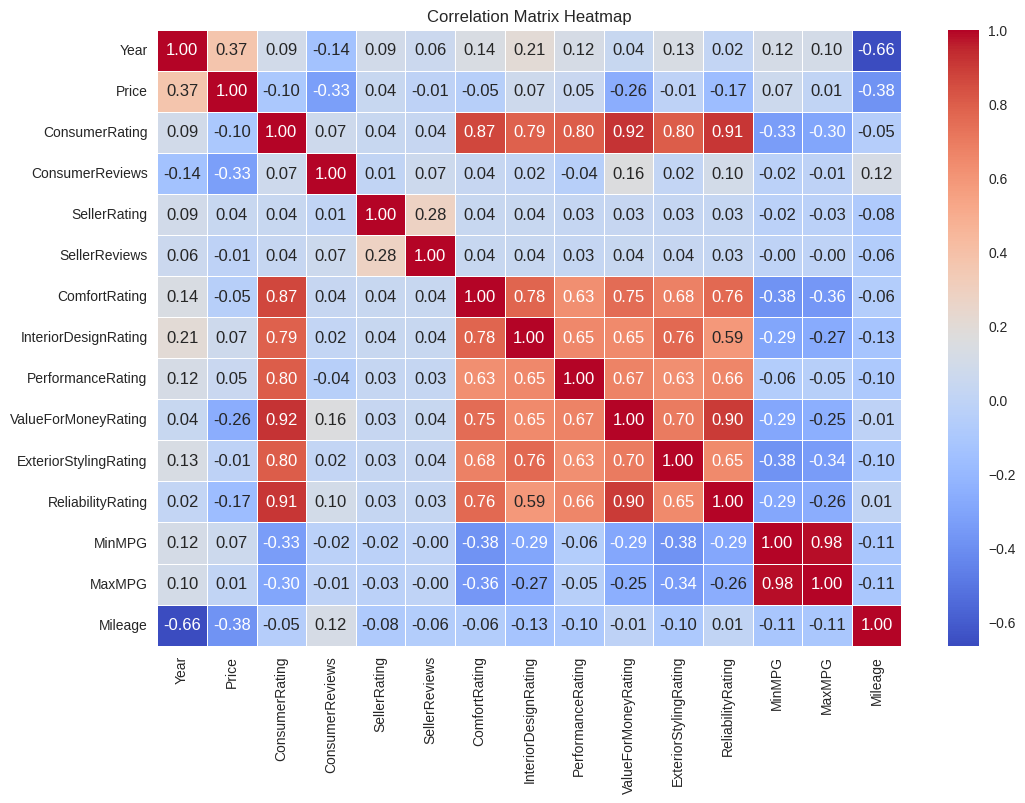

In [168]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


## multicolinerty olan sütunlar üstünde işlme

In [169]:
#df["Consumer_Rate"] = df.ConsumerRating * df.ConsumerReviews

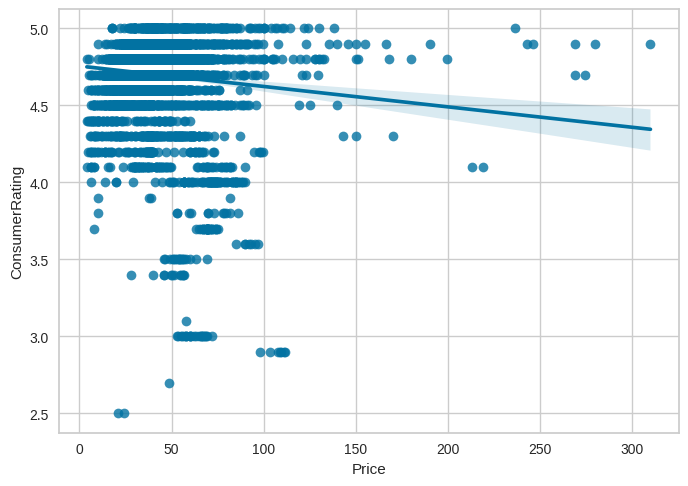

In [170]:
sns.regplot(data = df, x = "Price", y = "ConsumerRating");


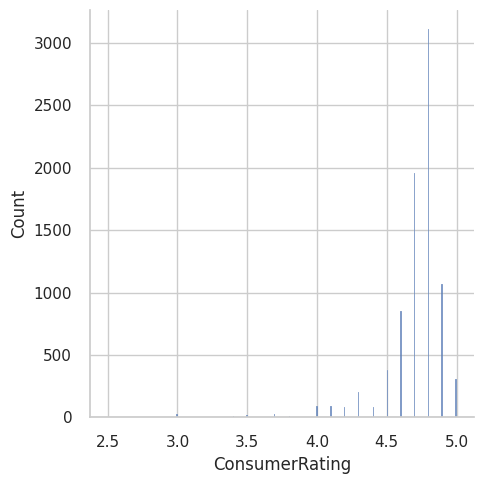

In [ ]:
sns.displot(x="ConsumerRating", data = df);


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF hesaplama
X = df[['ComfortRating', 'InteriorDesignRating', 'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                 feature          VIF
0          ComfortRating  1807.688837
1   InteriorDesignRating  2281.832922
2      PerformanceRating   787.611758
3    ValueForMoneyRating  1095.260675
4  ExteriorStylingRating  1639.386624
5      ReliabilityRating  1003.948249


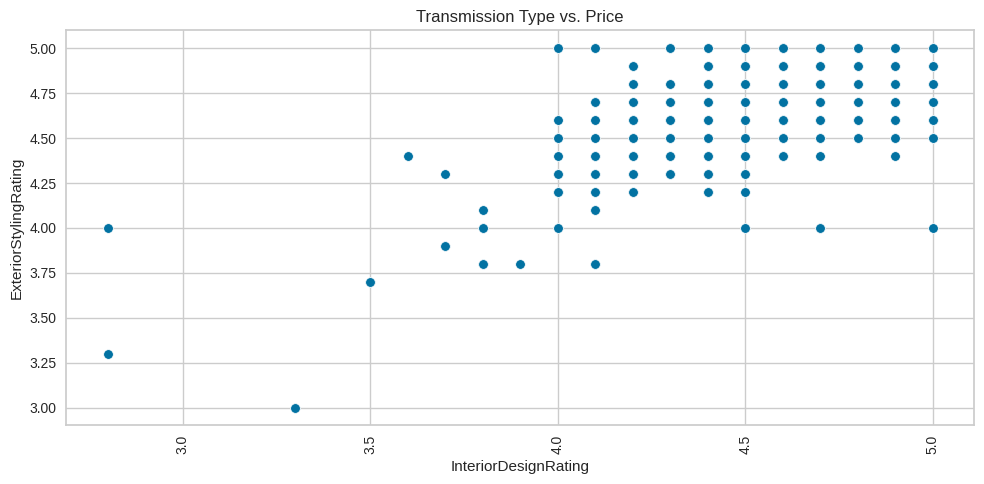

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='InteriorDesignRating', y='ExteriorStylingRating', data=df, palette='viridis')
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price')
plt.xlabel('InteriorDesignRating')
plt.ylabel('ExteriorStylingRating')
plt.tight_layout()
plt.show()

In [ ]:
#df['Rating'] = (df["ConsumerRating"]+df['ComfortRating'] + df['InteriorDesignRating'] + df['PerformanceRating'] + df['ValueForMoneyRating'] + df['ExteriorStylingRating'] + df['ReliabilityRating']) / 6


In [171]:
cars_owner_rate = (df.ValueForMoneyRating * df.ReliabilityRating)
df["cars_owner_rate"] = cars_owner_rate

In [172]:
df['weighted_consumer_rating'] = 0.7 * df['cars_owner_rate'] + 0.3 * df['ConsumerRating']


In [173]:
df.drop(['cars_owner_rate','ConsumerRating','ComfortRating', 'InteriorDesignRating', 'PerformanceRating', 'ValueForMoneyRating', 'ExteriorStylingRating', 'ReliabilityRating'], axis=1, inplace=True)

In [174]:
to_drop = df[(df["MinMPG"] == 0) & (df["MaxMPG"] == 0)].index

df.drop(index=to_drop, inplace=True)

In [175]:
max = df[df["MaxMPG"] == 0].index
df.drop(index=max, inplace=True)

In [176]:
min= df[df["MinMPG"] == 0].index
df.drop(index=min, inplace=True)

In [177]:
MPG = df.MinMPG * df.MaxMPG
df["MPG"] = MPG
df.drop(["MinMPG", "MaxMPG"], axis=1, inplace=True)

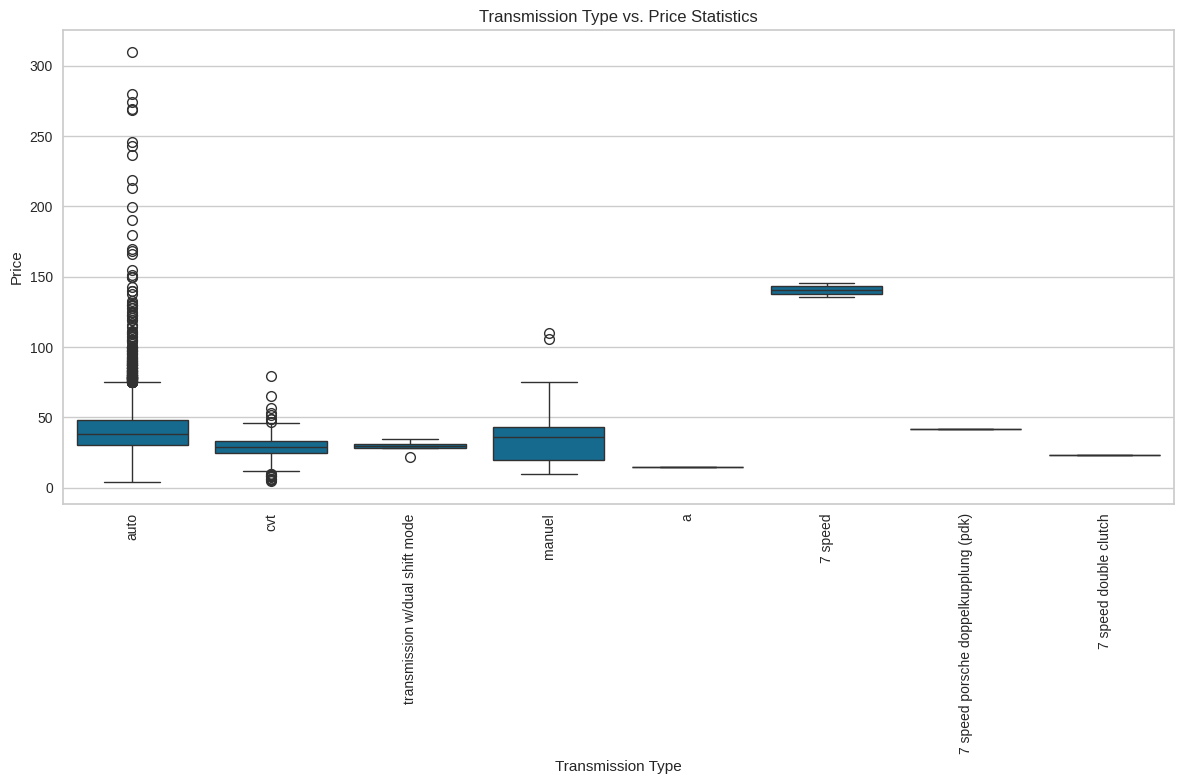

In [178]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Transmission_Type', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price Statistics')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [179]:
df["Transmission_Type"].value_counts()

auto                                    7111
cvt                                     1171
manuel                                    32
transmission w/dual shift mode             4
7 speed                                    2
a                                          1
7 speed porsche doppelkupplung (pdk)       1
7 speed double clutch                      1
Name: Transmission_Type, dtype: int64

In [180]:
df['Transmission_Type'] = df['Transmission_Type'].apply(lambda x: x if x in ['auto', 'cvt'] else 'other')


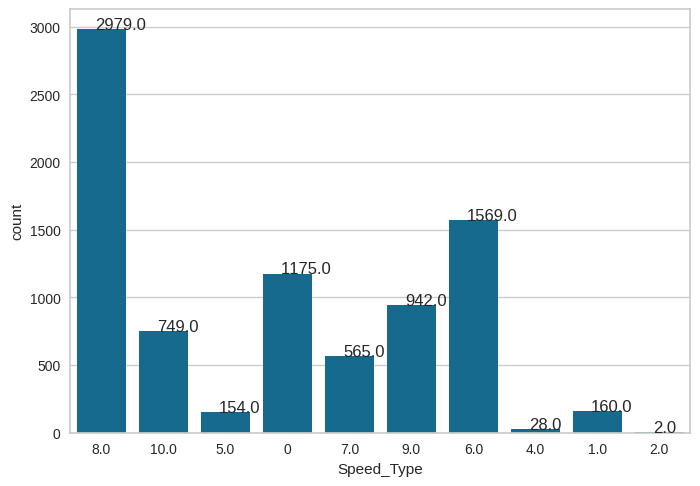

In [181]:
#Speed Type için de other sütunu kullanabilir miyiz?
fig, ax = plt.subplots()

sns.countplot(data = df, x = "Speed_Type");
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.3, p.get_height()+0.2))

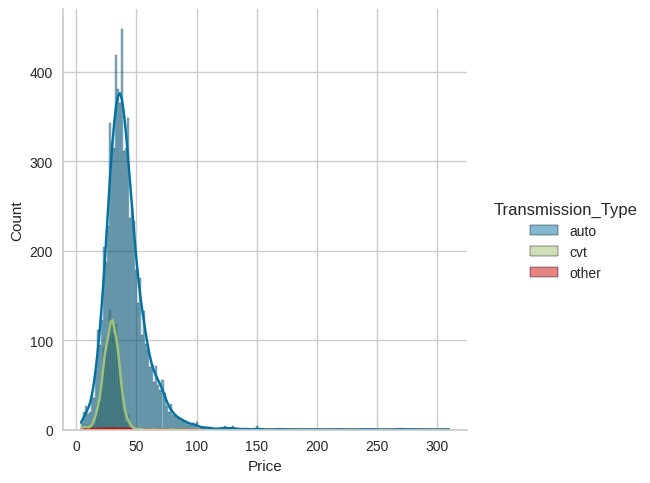

In [182]:
sns.displot(x = "Price", data = df, hue = "Transmission_Type", kde = True);


In [183]:
state_counts = df.State.value_counts()
rare_state = state_counts[state_counts < 130].index

# Bu değerleri "Other" olarak yeniden kategorize edin
df['State_1'] = df['State'].apply(lambda x: 'Other' if x in rare_state else x)


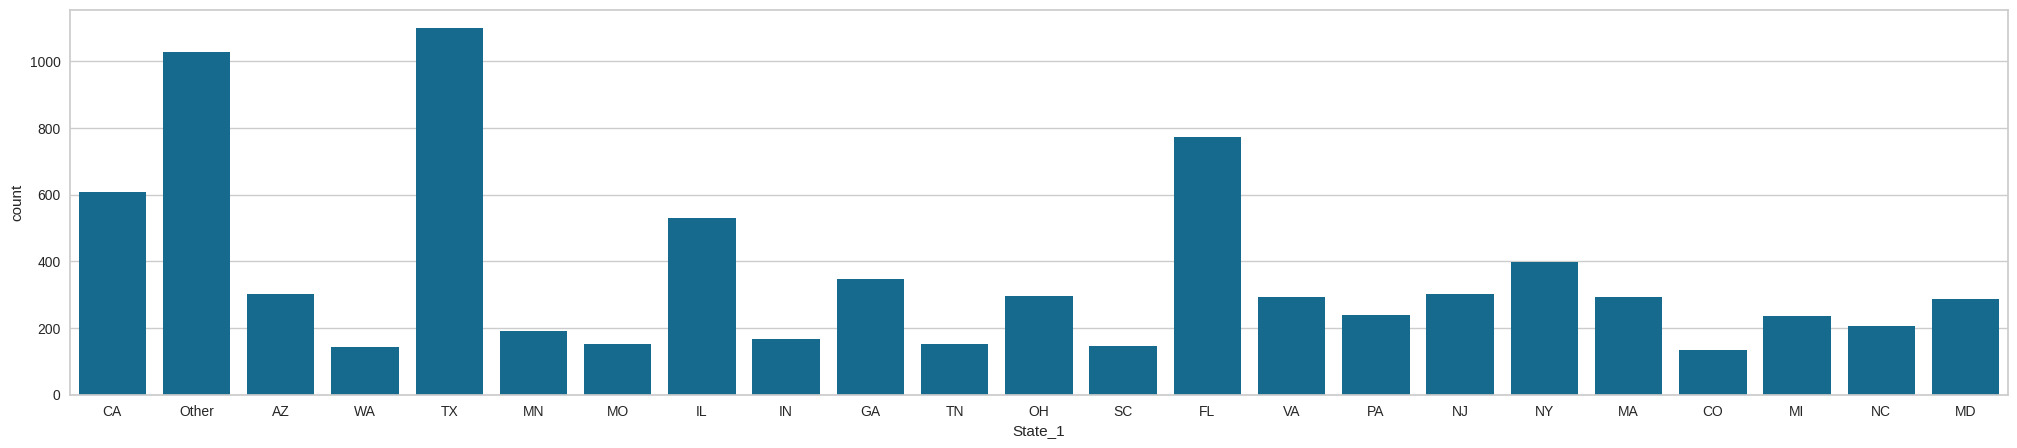

In [184]:
#State için de other sütunu kullanabilir miyiz?
plt.figure(figsize = (25,5))

sns.countplot(data = df, x = "State_1");


In [185]:
# kategorik verilerde unique değerlere baktık
for col in df.select_dtypes('object'):
    print(f"{col:<20}:", df[col].nunique())# col<20: çıktının daha okunabilri hale gelmesi için

Make                : 40
Model               : 1259
Used/New            : 2
SellerType          : 2
SellerName          : 3857
StreetName          : 3852
State               : 59
Zipcode             : 2107
DealType            : 3
ExteriorColor       : 923
InteriorColor       : 358
Drivetrain          : 4
FuelType            : 9
Transmission        : 63
Engine              : 291
VIN                 : 8290
Stock#              : 8262
Transmission_Type   : 3
Speed_Type          : 10
State_1             : 23


In [186]:
df.FuelType.value_counts()

Gasoline                         7943
Electric                          144
E85 Flex Fuel                     105
Hybrid                             62
Diesel                             36
Gasoline Fuel                      23
Gasoline/Mild Electric Hybrid       5
Flex Fuel Capability                3
Flexible Fuel                       2
Name: FuelType, dtype: int64

In [187]:
df['FuelType'] = df['FuelType'].replace({
    'Gasoline Fuel': 'Gasoline',
    'E85 Flex Fuel': 'Flex Fuel',
    'Flex Fuel Capability': 'Flex Fuel',
    'Gasoline/Mild Electric Hybrid': 'Hybrid',
    "Flexible Fuel" : "Flex Fuel"
})


In [188]:
df.FuelType.value_counts()

Gasoline     7966
Electric      144
Flex Fuel     110
Hybrid         67
Diesel         36
Name: FuelType, dtype: int64

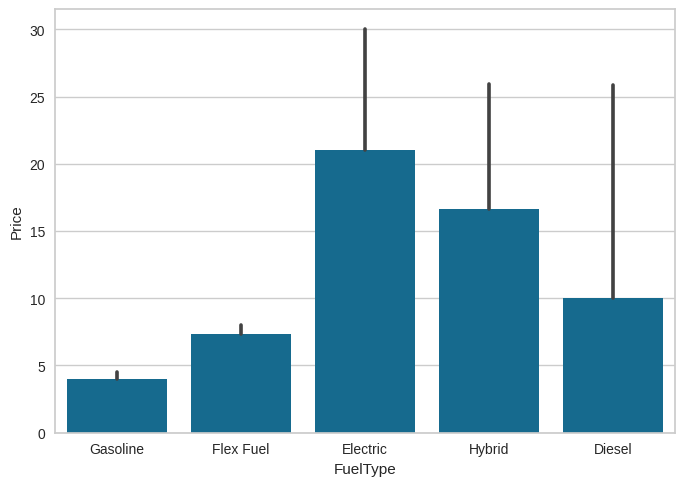

In [189]:
sns.barplot(x = "FuelType", y = "Price", data = df, estimator = np.min);
#burada bir belirsilik söz konusu

## Engine üstüne işlemler

In [190]:
df["Engine"]=df["Engine"].str.replace("-", "")

In [191]:
pattern_L = r"(\d+(\.\d+)?)\s*L\b"
pattern_VI = r"\b(V\d+|I\d+|H\d+)\b"
pattern_cylinder = r"(\d+)\s*cylinder\b|\b(\d+)\s*cyl\b|\b(\d+)\s*cyl\w*\b"

# Fonksiyonlar
def extract_litre(engine):
    match = re.search(pattern_L, engine)
    return match.group(1) if match else None

def extract_cylinder_arrangement(engine):
    match_VI = re.findall(pattern_VI, engine, flags=re.IGNORECASE)
    match_cylinder = re.findall(pattern_cylinder, engine, flags=re.IGNORECASE)

    if match_VI:
        return match_VI[-1]  # En son bulunan V veya I desenini döndür
    elif match_cylinder:
        for match in match_cylinder[0]:
            if match:
                return f"{match} Cylinder"  # Yakalanan silindir düzenini döndür
    else:
        return None

# Uygulama
df['Litre'] = df['Engine'].apply(extract_litre)
df.Litre = df.Litre.astype(float)
df['Cylindder_Arrangement'] = df['Engine'].apply(extract_cylinder_arrangement)

In [192]:
df[df.Cylindder_Arrangement.isna()==True]  # mesela burda elektrikli araçların litre türünden motor hacmi olmazmış ynai yokmuş aslında bunlar drop edilebilir
#ama ben 0 ile dolduracağım
df.Litre = df.Litre.fillna(0)

In [193]:
df

Year     Make                   Model Used/New   Price  ConsumerReviews  \
0     2019   Toyota               Sienna SE     Used  39.998               45   
1     2018     Ford            F-150 Lariat     Used  49.985              817   
2     2017      RAM            1500 Laramie     Used  41.860              495   
4     2020    Lexus                  RX 350     Used  49.000               76   
5     2012   Toyota             4Runner SR5     Used  23.541               34   
...    ...      ...                     ...      ...     ...              ...   
8502  2019    Honda               CR-V EX-L     Used  31.999              540   
8503  2019   Subaru  Crosstrek 2.0i Premium     Used  27.374              205   
8504  2017    Buick         Enclave Leather     Used  26.944              137   
8505  2019   Subaru        Forester Premium     Used  28.568              279   
8506  2019  Hyundai   Santa Fe Ultimate 2.4     Used  32.091              204   

     SellerType  \
0        Dealer   
1        Dealer   
2        Dealer   
4        Dealer   
5        Dealer   
...         ...   
8502     Dealer   
8503     Dealer   
8504     Dealer   
8505     Dealer   
8506     Dealer   

                                                            SellerName  \
0     CarMax Murrieta - Now offering Curbside Pickup and Home Delivery   
1                                                      Giant Chevrolet   
2                                               Gill Auto Group Madera   
4                                                   Lexus of Henderson   
5                                            AutoNation Toyota Hayward   
...                                                                ...   
8502                                                     Hoffman Honda   
8503                                Bertera Subaru of West Springfield   
8504                                           Tulley Automotive Group   
8505                                                        Ira Subaru   
8506                                                  Route 44 Hyundai   

      SellerRating  SellerReviews                          StreetName State  \
0              3.3              3          25560 Madison Ave Murrieta    CA   
1              4.8            131       1001 S Ben Maddox Way Visalia    CA   
2              4.6            249            1100 S Madera Ave Madera    CA   
4              4.8           4755          7737 Eastgate Rd Henderson    NV   
5              4.4           1071          24773 Mission Blvd Hayward    CA   
...            ...            ...                                 ...   ...   
8502           4.8           1917        40 Albany Tpke West Simsbury    CT   
8503           4.4            443  657 Riverdale St. West Springfield    MA   
8504           4.7            831       147 Daniel Webster Hwy Nashua    NH   
8505           4.4            680               97 Andover St Danvers    MA   
8506           4.4           1105          1094 New State Hwy Raynham    MA   

     Zipcode DealType                       ExteriorColor InteriorColor  \
0      92562    Great                                 Red         Black   
1      93292     Good                        Shadow Black         Black   
2      93637     Good  Granite Crystal Clearcoat Metallic         Black   
4      89011     Good                 Eminent White Pearl         Birch   
5      94544     Fair                               Black             –   
...      ...      ...                                 ...           ...   
8502   06092     Good                 Obsidian Blue Pearl             –   
8503   01089     Good                   Quartz Blue Pearl          Gray   
8504   03060     Good             Ebony Twilight Metallic         Ebony   
8505   01923     Good                Crystal Black Silica         Black   
8506   02767     Good                      Twilight Black         Black   

     Drivetrain  FuelType        Transmission  \
0           FWD 

In [194]:
df[df.Cylindder_Arrangement.isna()==True]["Engine"].value_counts()

Electric                                           141
2.0L                                                28
2.5L                                                 7
Electric Motor                                       2
0.0                                                  2
0 0.0                                                1
6.0L W12 48V MPFI DOHC Twin Turbo                    1
Turbocharged Gas 1.5L/92                             1
NOT SPECIFIED NOT SPECIFIED                          1
6.0L W12 48V MPFI DOHC Twin Turbo Flexible Fuel      1
3.0L                                                 1
0 MOTOR AC PERMANENT MAGNET                          1
Name: Engine, dtype: int64

In [195]:
df.Cylindder_Arrangement = df.Cylindder_Arrangement.str.replace("4 Cylinder", "I4").replace("6 Cylinder", "V6").replace("8 Cylinder", "V8").replace("10 Cylinder", "V10")

In [196]:
df[df.Cylindder_Arrangement.isna() == True]

Year     Make                Model Used/New   Price  ConsumerReviews  \
163   2020    Tesla   Model Y Long Range     Used  65.995               10   
171   2021    Tesla   Model Y Long Range     Used  71.277               15   
177   2020    Tesla   Model Y Long Range     Used  73.992               10   
285   2021    Tesla  Model Y Performance     Used  74.799               15   
299   2021    Tesla   Model Y Long Range     Used  74.900               15   
...    ...      ...                  ...      ...     ...              ...   
8252  2019  Hyundai      Kona EV Limited     Used  31.975               13   
8279  2022  Hyundai           IONIQ 5 SE     Used  54.999                6   
8351  2020    Tesla   Model Y Long Range     Used  64.990               10   
8388  2018    Tesla         Model X 100D     Used  82.350               15   
8491  2019    Tesla   Model 3 Long Range     Used  54.998               33   

     SellerType                           SellerName  SellerRating  \
163      Dealer                   Victory Mitsubishi           3.4   
171      Dealer                       AutoFair Honda           4.8   
177      Dealer                     Gilroy Chevrolet           4.6   
285      Dealer              INFINITI of San Antonio           4.7   
299      Dealer    Heartland Chrysler Dodge Jeep Ram           4.5   
...         ...                                  ...           ...   
8252     Dealer                      Bill Luke Tempe           4.8   
8279     Dealer                  Hyundai of Palatine           4.5   
8351     Dealer                  Dallas Autos Direct           4.4   
8388     Dealer  Sheehy Ford Lincoln of Gaithersburg           4.9   
8491     Dealer       Delaware Cadillac, Subaru, Kia           4.8   

      SellerReviews                               StreetName State Zipcode  \
163             472                     4070 Boston rd Bronx    NY   10475   
171            3306             200 Keller Street Manchester    NH   03103   
177             143                  6720 Automall Ct Gilroy    CA   95020   
285             507                   12150 I-10 San Antonio    TX   78230   
299             111  2017 W Jesse James Rd Excelsior Springs    MO   64024   
...             ...                                      ...   ...     ...   
8252           1105               7833 S Autoplex Loop Tempe    AZ   85284   
8279            481              221 E Lake Cook Rd Palatine    IL   60074   
8351            333               3228 Skylane Dr Carrollton    TX   75006   
8388           3110       901 N. Frederick Ave. Gaithersburg    MD   20879   
8491            944         1606 Pennsylvania Ave Wilmington    DE   19806   

     DealType       ExteriorColor  InteriorColor Drivetrain  FuelType  \
163     Great                Blue              –        AWD  Electric   
171      Good   Pearl White Multi  White / Black        AWD  Electric   
177      Good               White  White / Black        AWD  Electric   
285      Good   Pearl White Multi  White / Black        AWD  Electric   
299      Good               White          Black        AWD  Electric   
...       ...                 ...            ...        ...       ...   
8252     Good       Galactic Gray          Black        FWD  Electric   
8279     Good       Phantom Black           Gray        AWD  Electric   
8351     Good               Black          Black        AWD  Electric   
8388     Fair  Deep Blue Metallic          Black        AWD  Electric   
8491     Good           Red Multi          Black        RWD  Electric   

           Transmission    Engine                VIN     Stock#  Mileage  \
163   1 speed automatic  Electric  5YJYGDEE8LF049382      17666     9561   
171   1 speed automatic  Electric  5YJYGDEE4MF086057   HM11774C    15002   
177   1 speed automatic  Electric  5YJYGDEEXLF020479  LF020479T    12332   
285   1 speed automatic  Electric  5YJYGDEFXMF076271   MF076271    12708   
299   1 speed automatic  Electric 

In [197]:
df.Cylindder_Arrangement.value_counts(dropna = False)  #artık 9 tane unique değerimiz var ve de 186 tane none değerimiz

I4      3642
V6      2773
V8       993
I6       407
H4       242
None     187
H6        32
I3        22
V10       18
I5         7
Name: Cylindder_Arrangement, dtype: int64

In [198]:
engine_na = (df['Engine'].str.contains("Electric")) & (df['Cylindder_Arrangement'].isna())

# Bu satırların 'Cylinder_Arrangement' sütununu "Electric" ile dolduruyoruz
df.loc[engine_na, 'Cylindder_Arrangement'] = "electric"

In [199]:
df.dropna(subset=["Cylindder_Arrangement"], inplace=True)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8279 entries, 0 to 8506
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      8279 non-null   int64  
 1   Make                      8279 non-null   object 
 2   Model                     8279 non-null   object 
 3   Used/New                  8279 non-null   object 
 4   Price                     8279 non-null   float64
 5   ConsumerReviews           8279 non-null   int64  
 6   SellerType                8279 non-null   object 
 7   SellerName                8279 non-null   object 
 8   SellerRating              8279 non-null   float64
 9   SellerReviews             8279 non-null   int64  
 10  StreetName                8279 non-null   object 
 11  State                     8279 non-null   object 
 12  Zipcode                   8279 non-null   object 
 13  DealType                  8279 non-null   object 
 14  Exterior

In [201]:
df.drop(["Engine","Transmission"], axis=1, inplace=True)

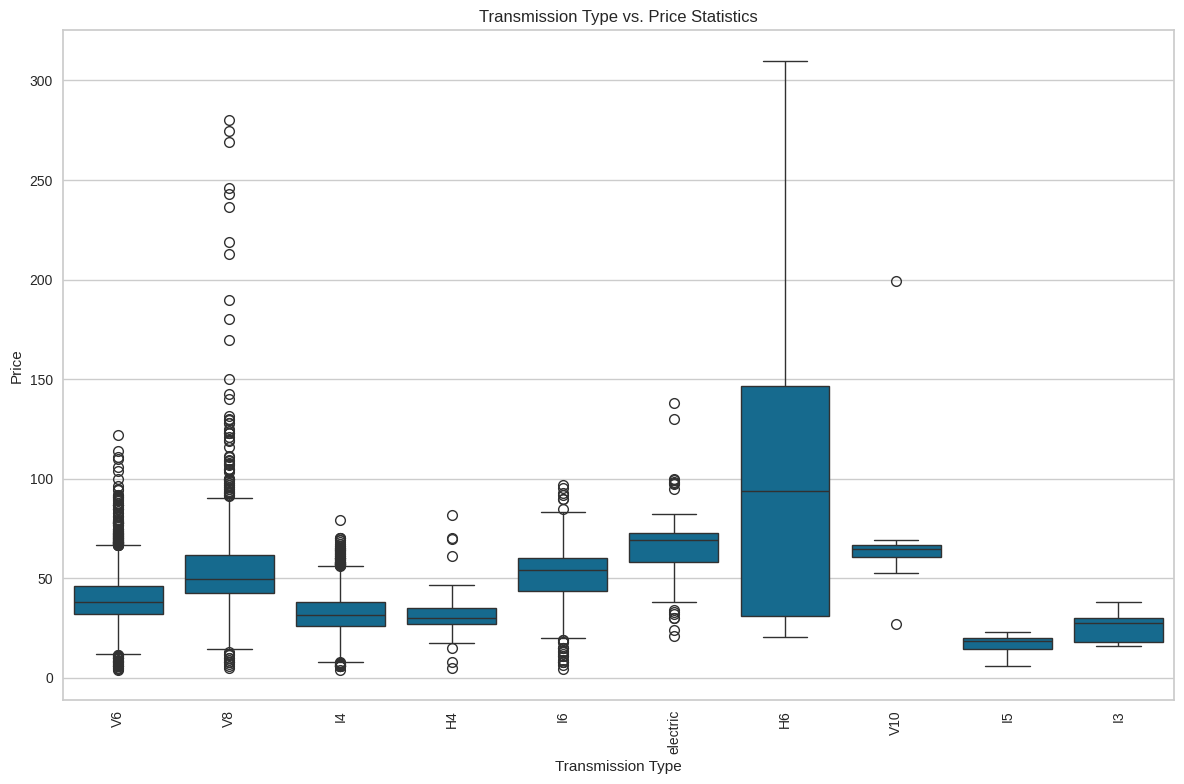

In [202]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cylindder_Arrangement', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Transmission Type vs. Price Statistics')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

 # Create Columns

In [203]:
df["Make-Model"] = df["Make"] + " " + df["Model"]

In [204]:
make_counts = df["Make"].value_counts()

In [205]:
rare_make = make_counts[make_counts < 100].index

# Bu değerleri "Other" olarak yeniden kategorize edin
df['Make'] = df['Make'].apply(lambda x: 'Other' if x in rare_make else x)


In [206]:
rare_make

Index(['Alfa', 'Chrysler', 'Jaguar', 'Mitsubishi', 'Genesis', 'Maserati',
       'Lamborghini', 'MINI', 'Scion', 'Mercury', 'FIAT', 'Bentley', 'Saturn'],
      dtype='object')

In [41]:
df["Make"].value_counts()

BMW              835
Mercedes-Benz    736
Toyota           711
Honda            616
Ford             518
Jeep             457
Lexus            442
Chevrolet        380
Audi             348
Subaru           254
Cadillac         250
Nissan           232
Kia              214
GMC              213
Acura            206
Hyundai          200
INFINITI         190
Mazda            172
Other            166
Land             154
Tesla            142
RAM              135
Dodge            129
Volkswagen       127
Volvo            127
Porsche          112
Lincoln          110
Buick            103
Name: Make, dtype: int64

In [207]:
model_count = df.groupby("Make")["Model"].count().reset_index()
model_count.columns = ["Make", "Count_of_model"]

# df veri çerçevenize "Count_of_model" sütununu ekleyin
df = pd.merge(df, model_count, on="Make", how="left")

In [208]:
df.drop(columns=['Make-Model'], inplace=True)


In [209]:
year_of_age = 2024 - df.Year
df["year_of_age"] = year_of_age

In [125]:
df.to_csv("new_df.csv", index=False)

KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

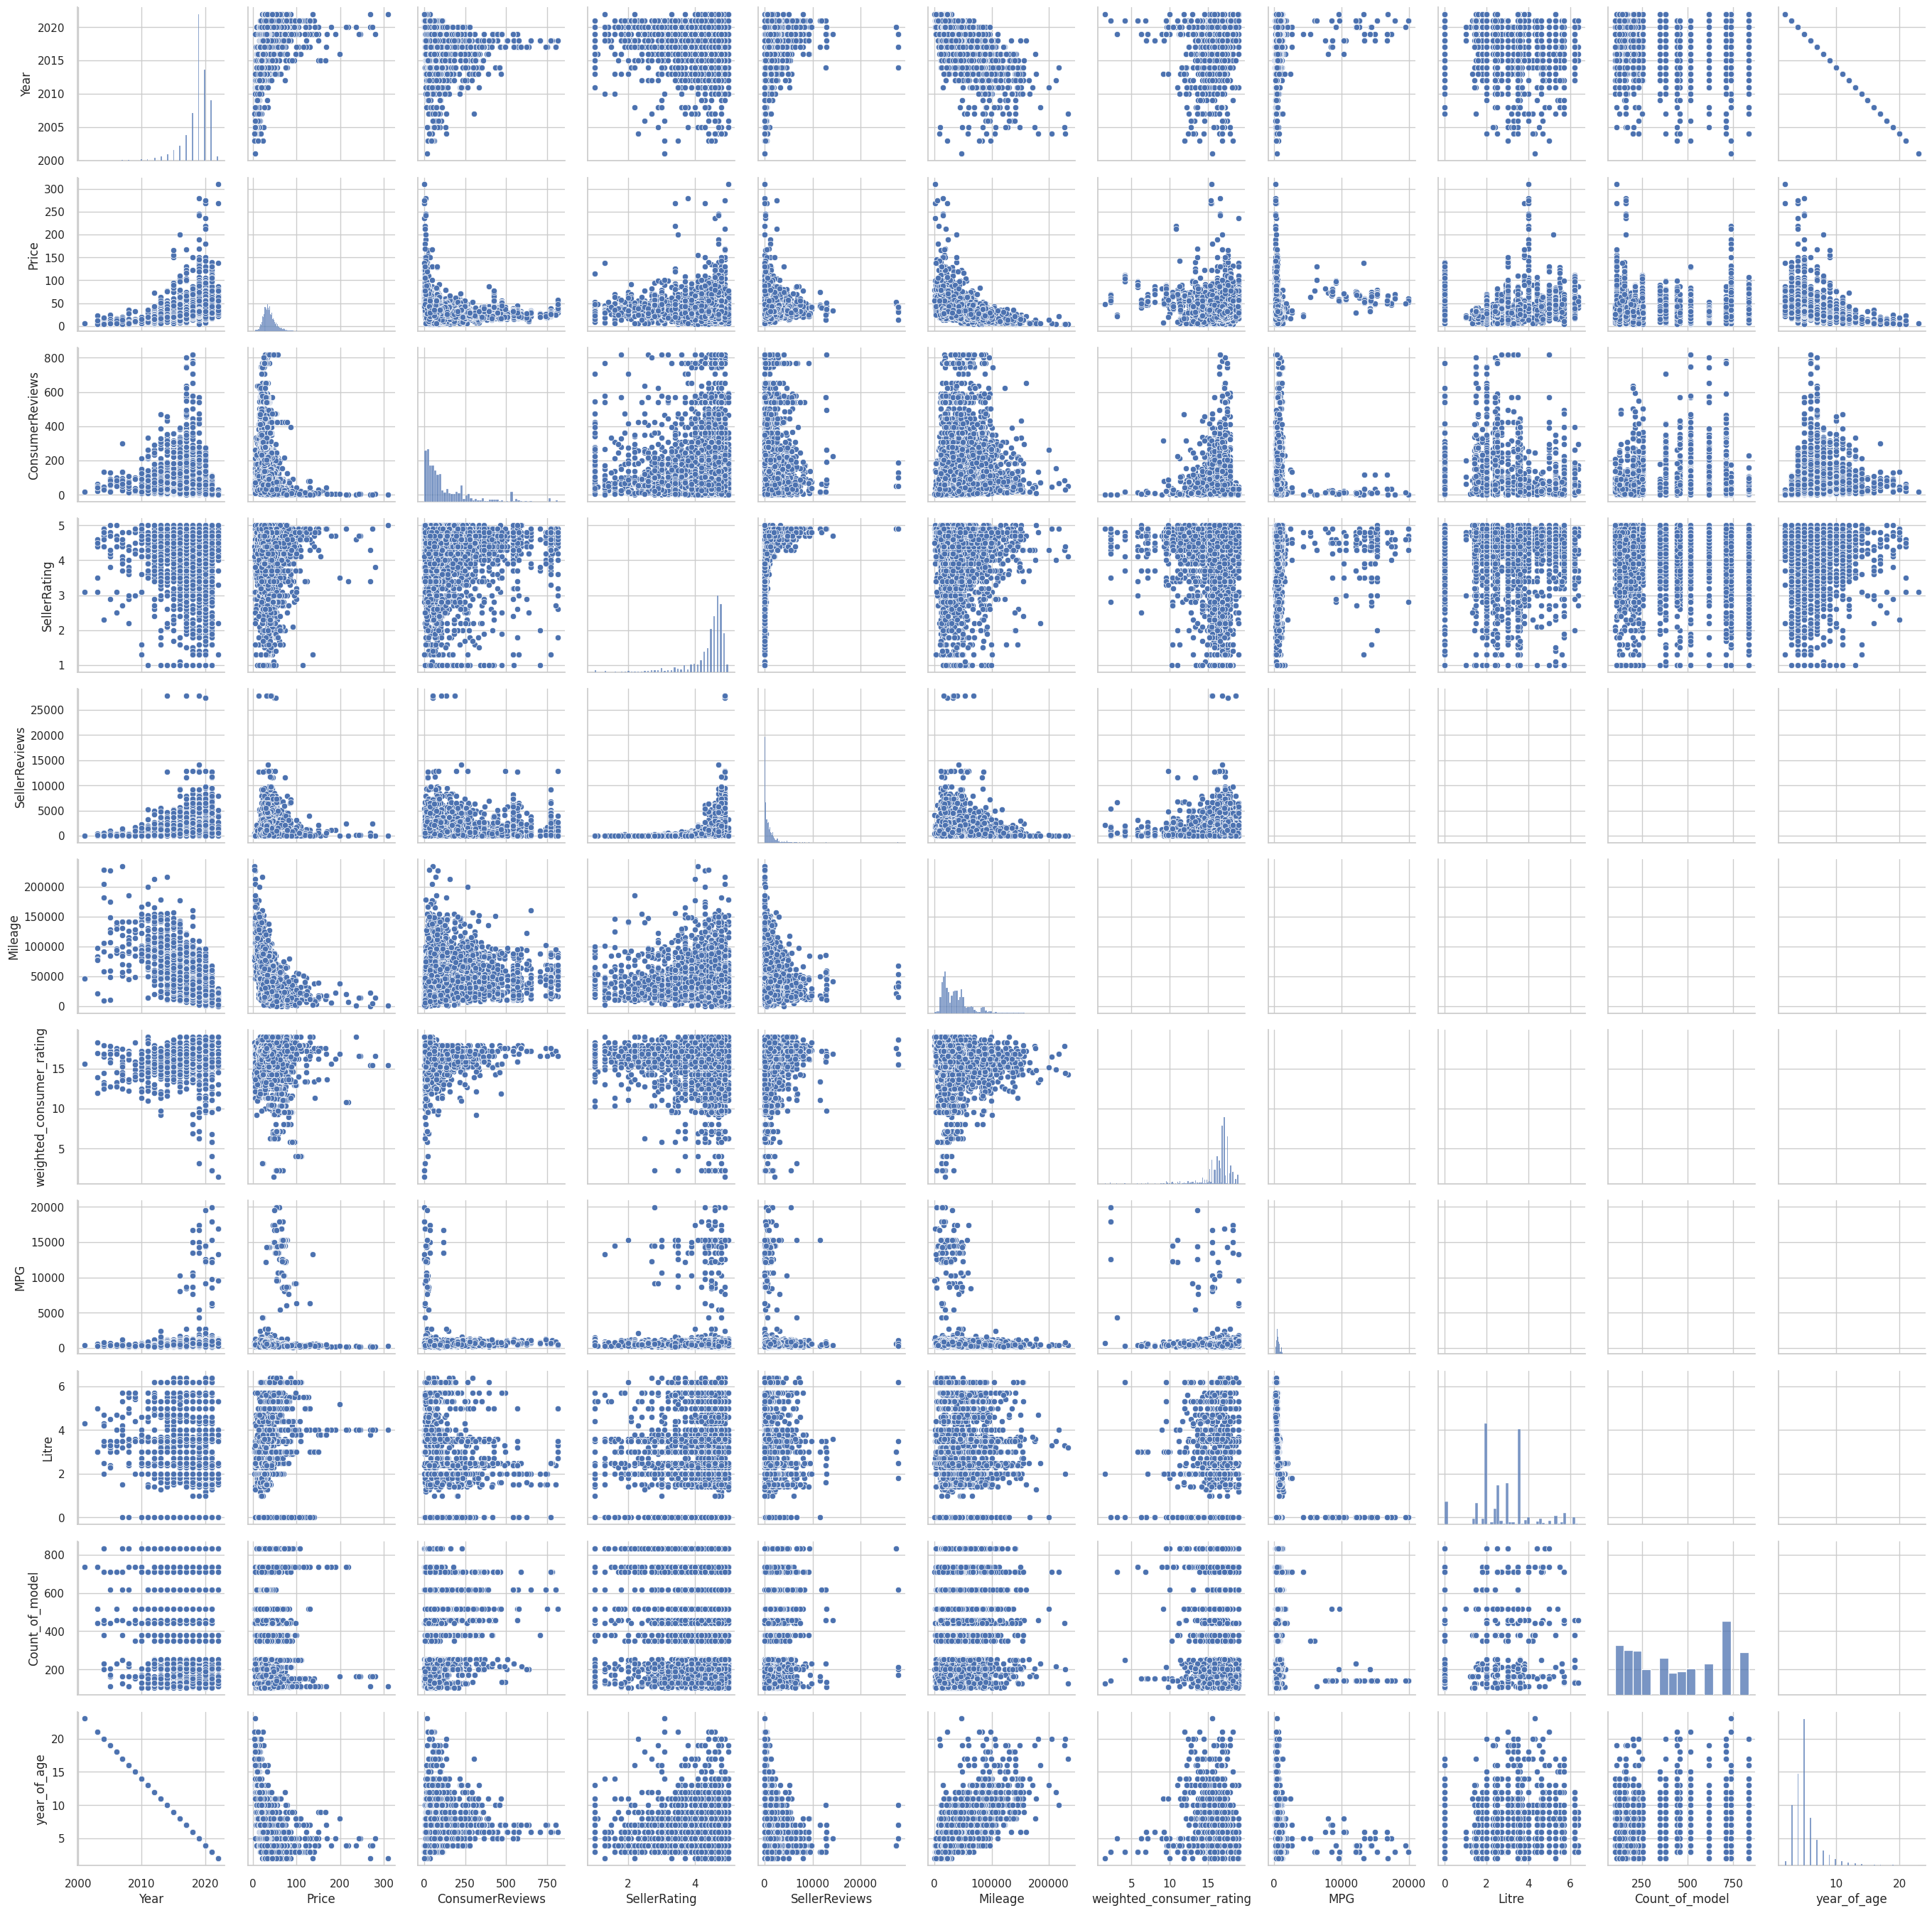

In [ ]:
plt.figure(figsize=(12, 6))
sns.pairplot(df, palette="Dark2")

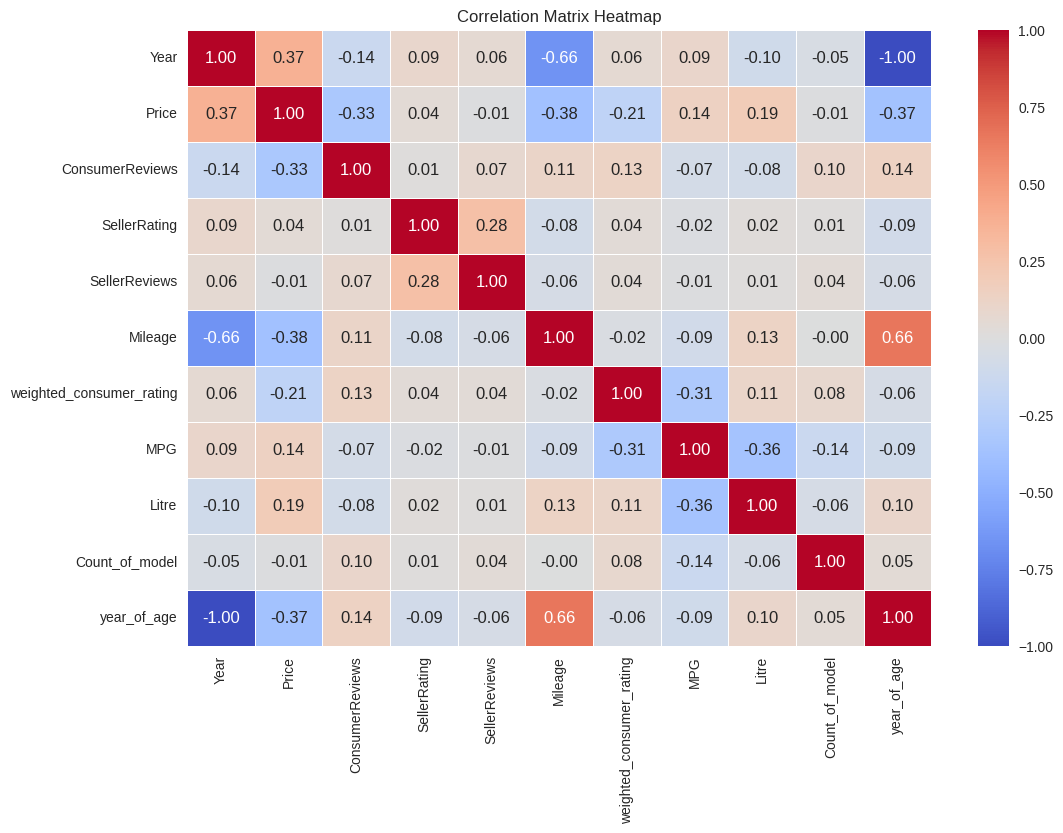

In [42]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [210]:
from sklearn.decomposition import PCA  #modele dezavantaj var tahminleme sonucunda
from sklearn.preprocessing import StandardScaler

# Veriyi ölçeklendirme
features = ['Mileage', 'year_of_age']
x = df[features].values
x = StandardScaler().fit_transform(x)

# PCA uygulama
pca = PCA(n_components=1)
principal_component = pca.fit_transform(x)

# Yeni bileşeni DataFrame'e ekleme
df['Mileage_Year'] = principal_component


In [211]:
df.drop(['Mileage', 'year_of_age'], axis=1, inplace=True)

MinMPG: Şehir içi yakıt verimliliğini belirtir. Daha düşük değerler gösterir.
MaxMPG: Şehir dışı yakıt verimliliğini belirtir. Daha yüksek değerler gösterir.

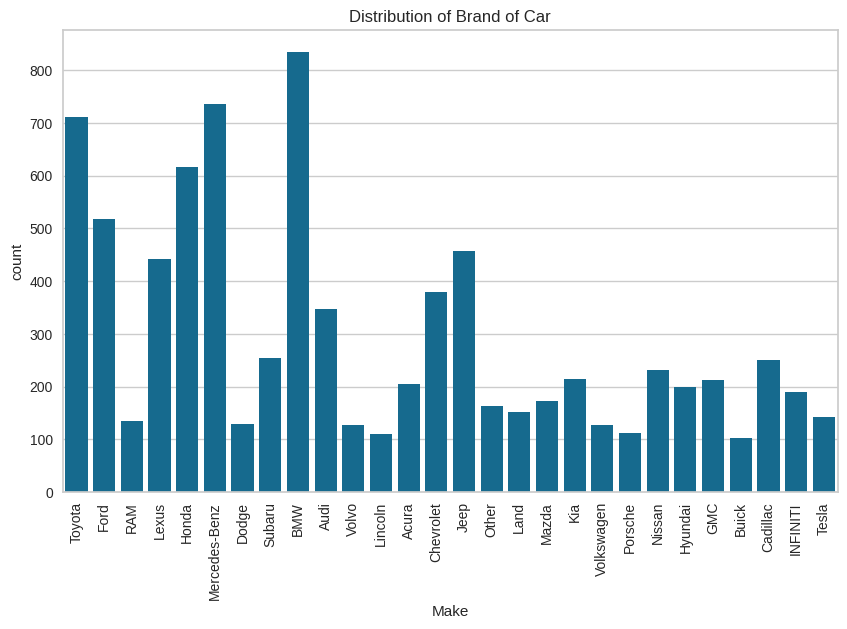

In [45]:
categorical_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Make')
plt.title(f'Distribution of Brand of Car')
plt.xticks(rotation=90)
plt.show()


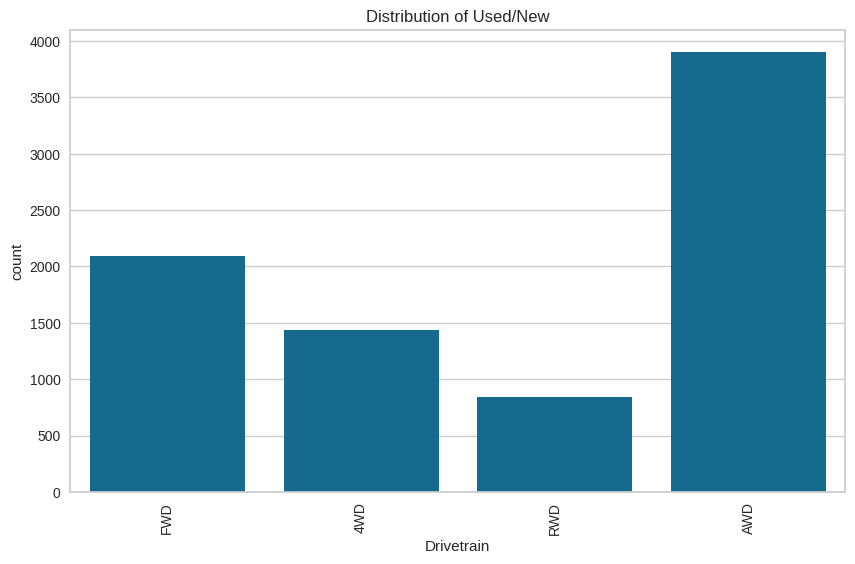

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Drivetrain')
plt.title(f'Distribution of Used/New')
plt.xticks(rotation=90)
plt.show()


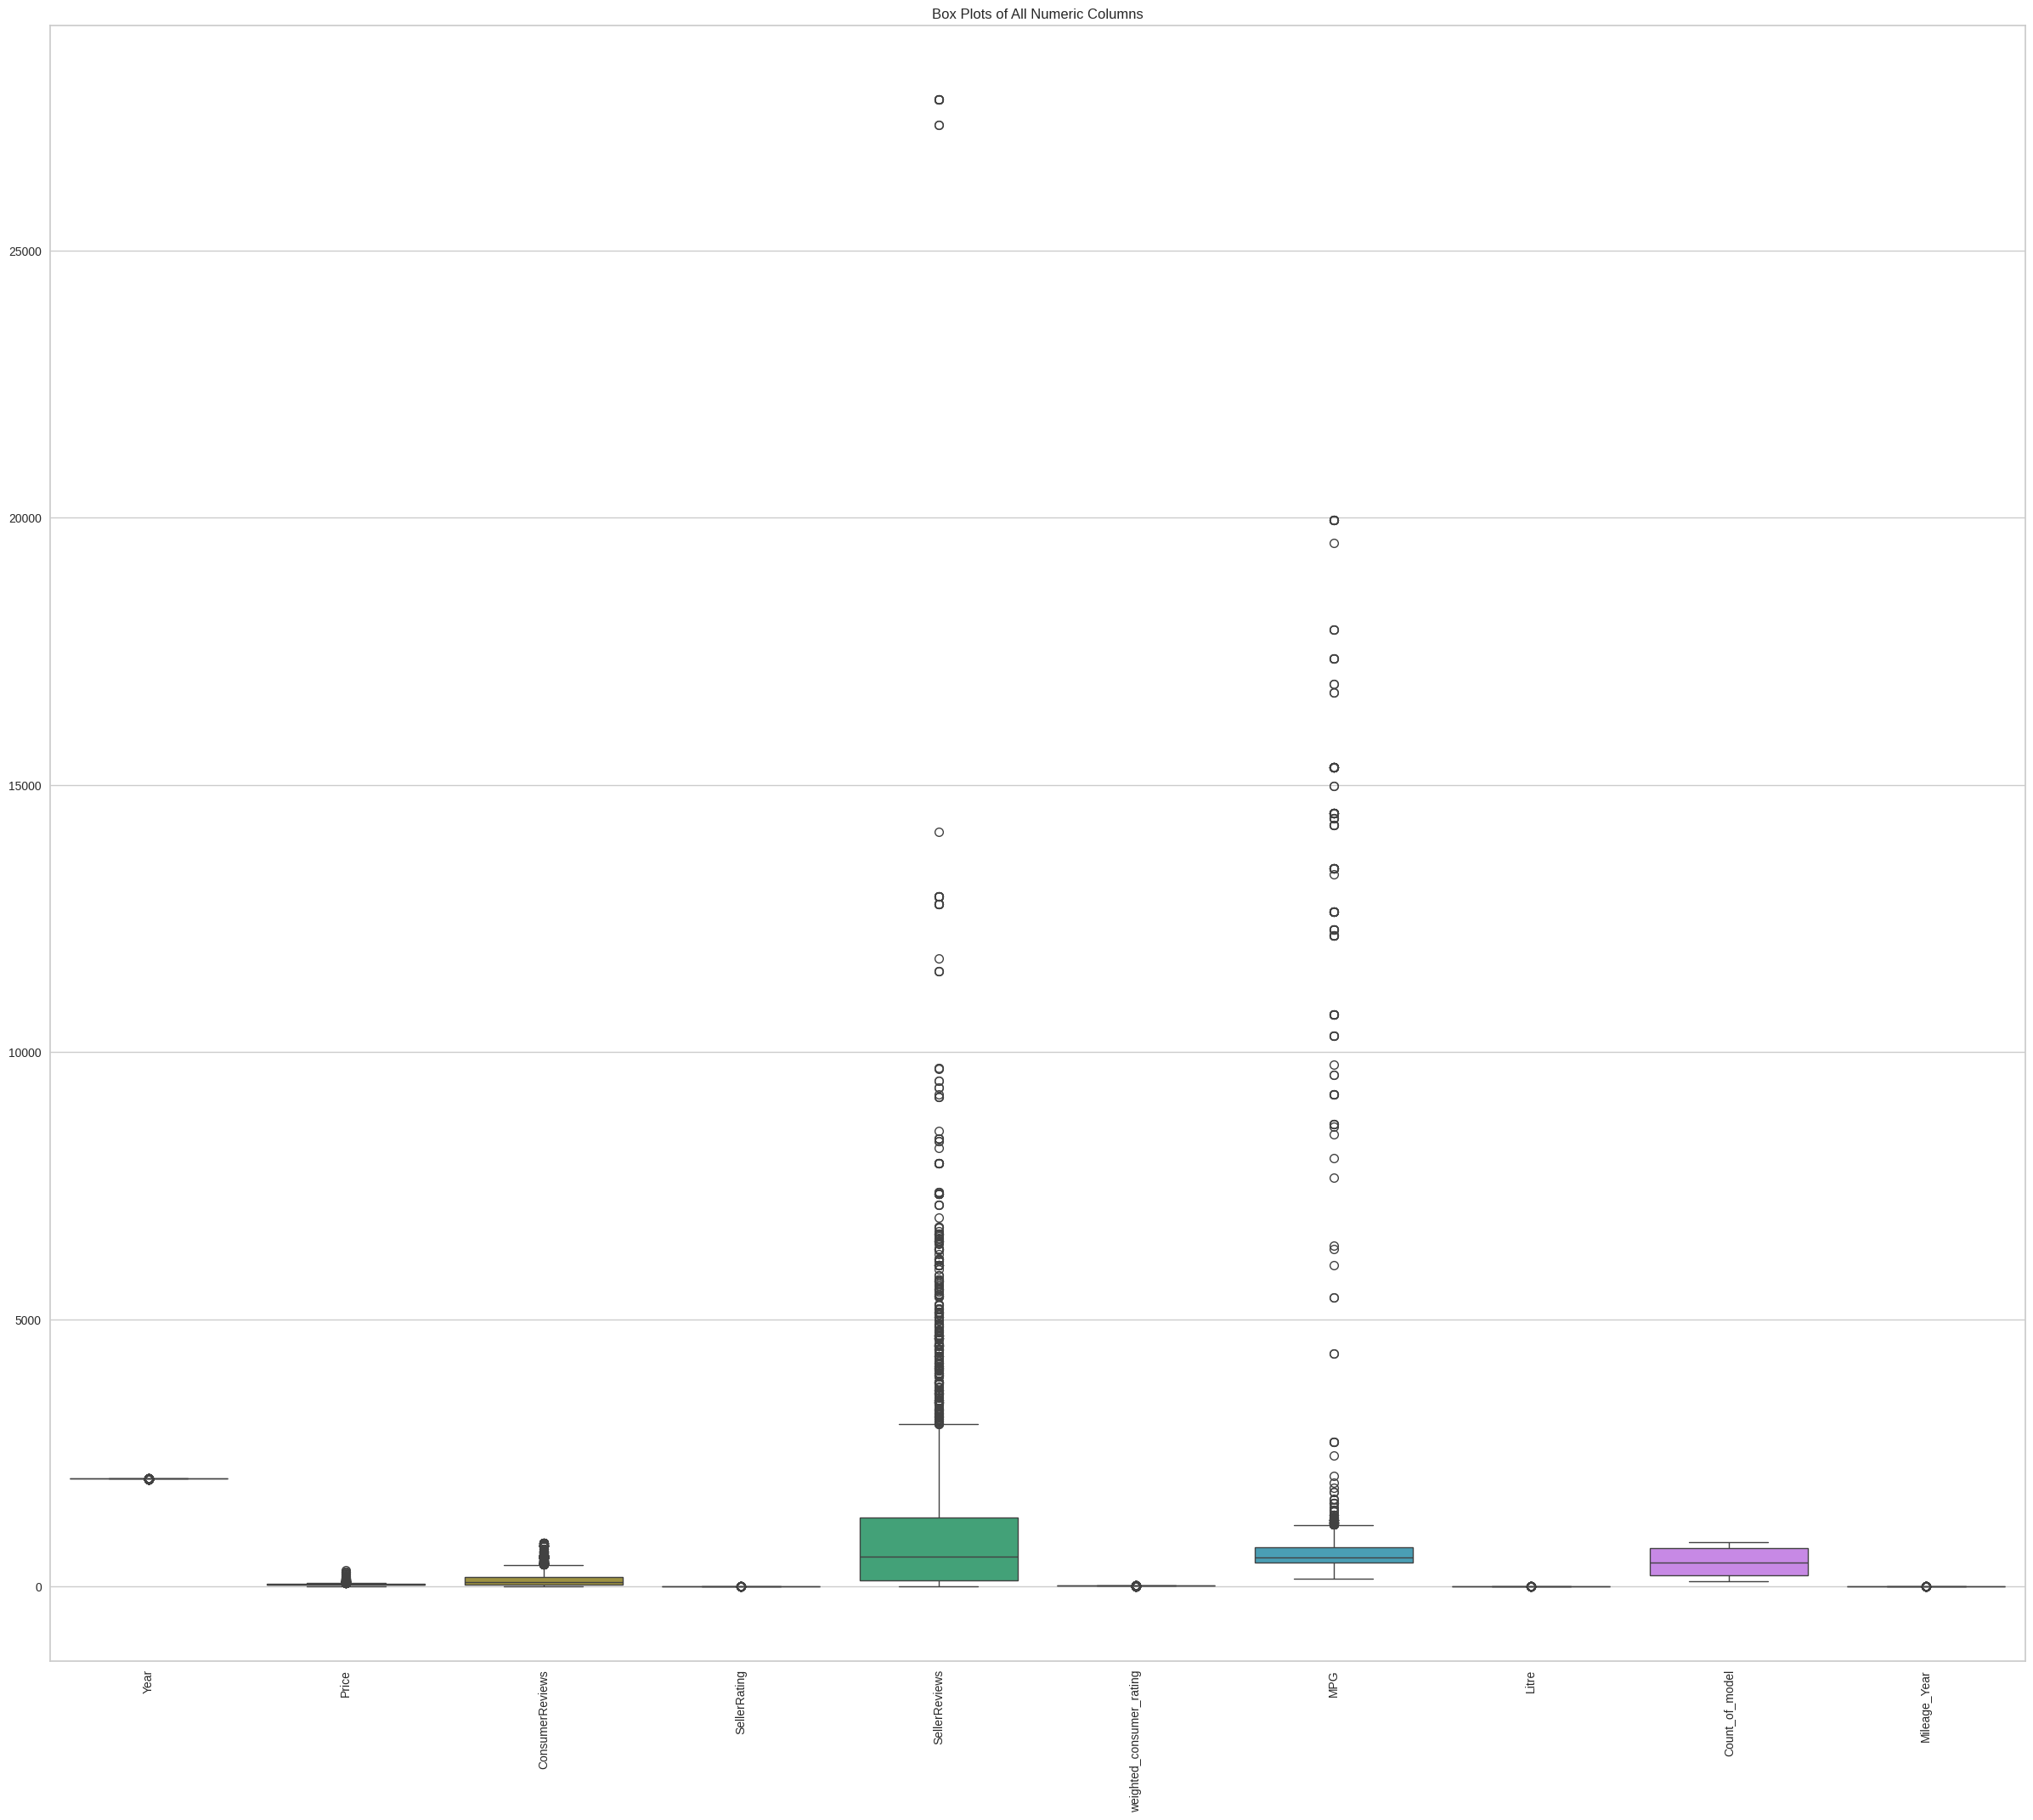

In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(30, 25))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=90)
plt.title('Box Plots of All Numeric Columns')
plt.show()


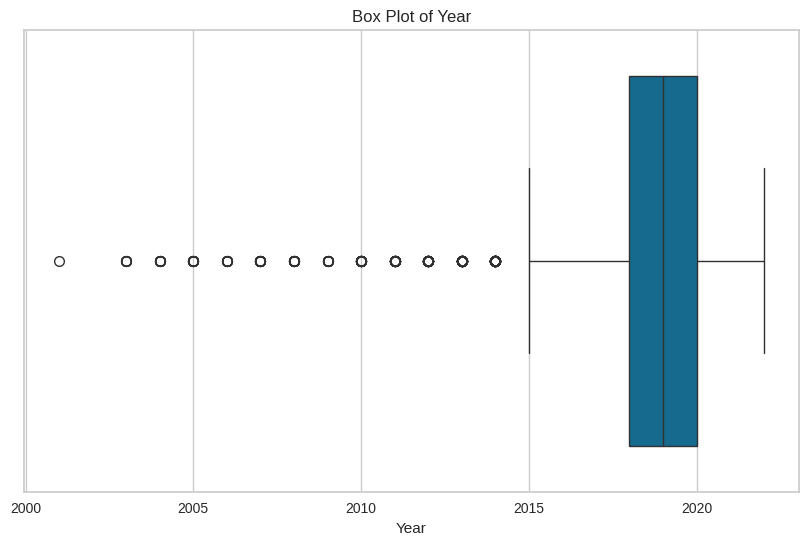

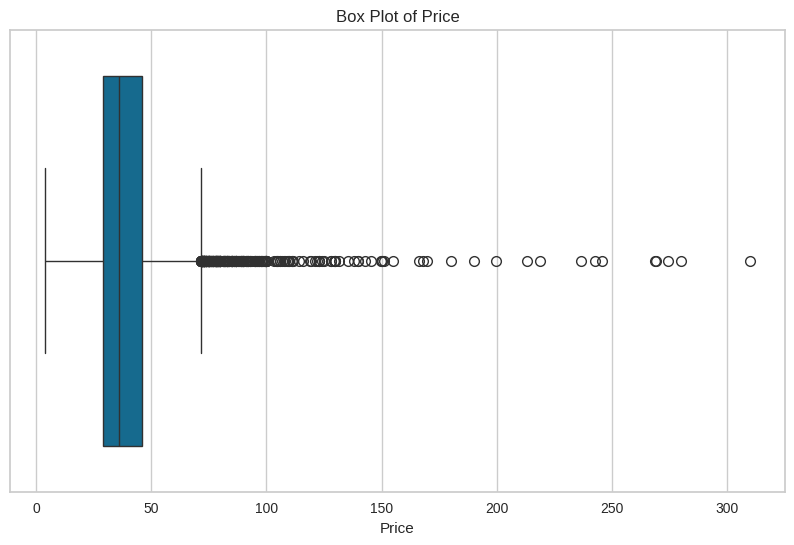

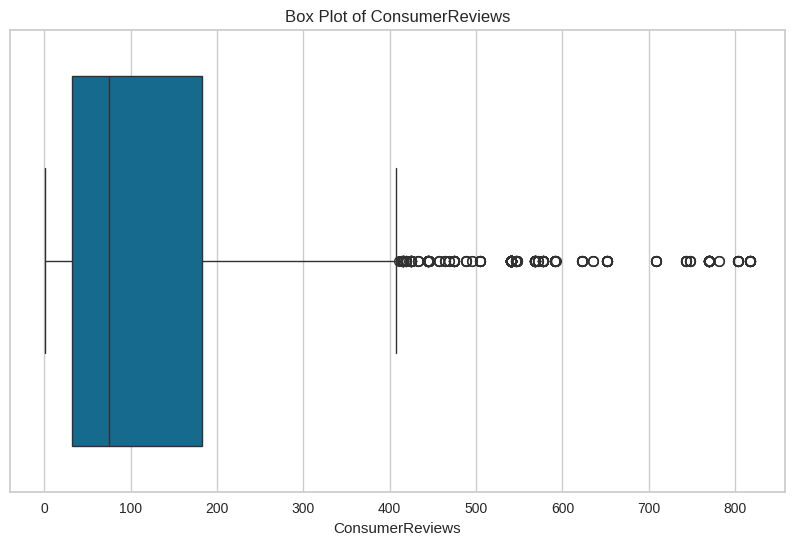

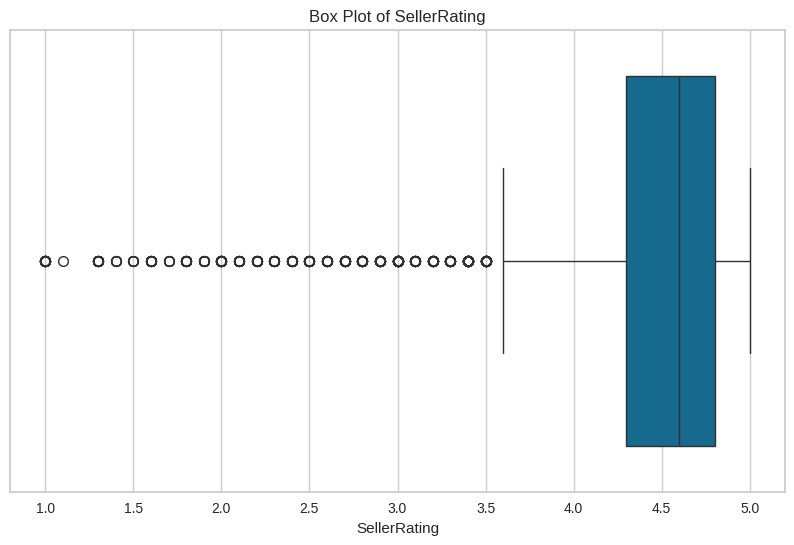

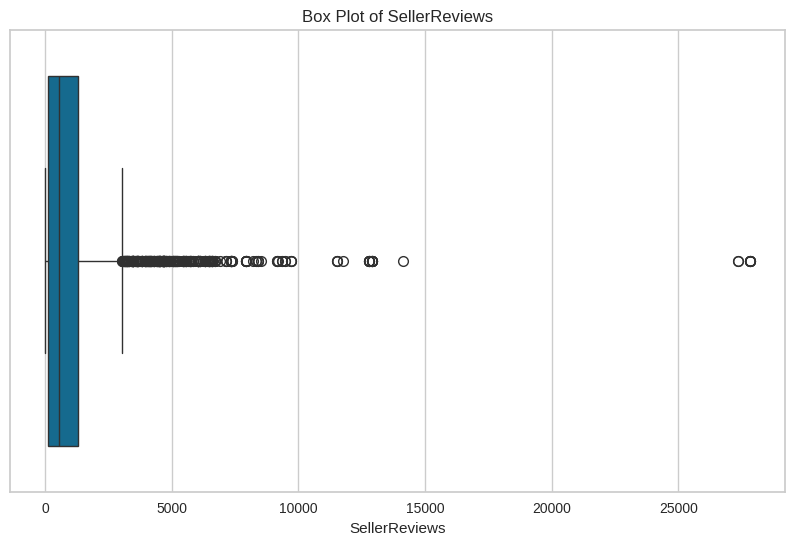

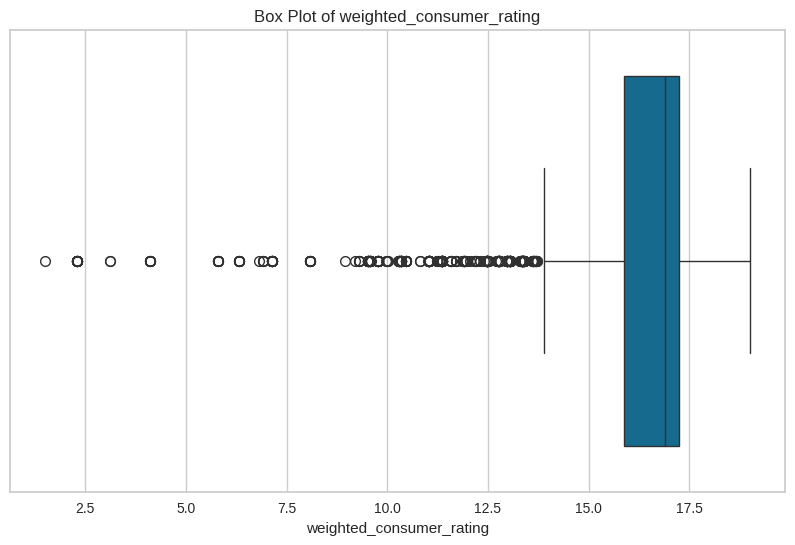

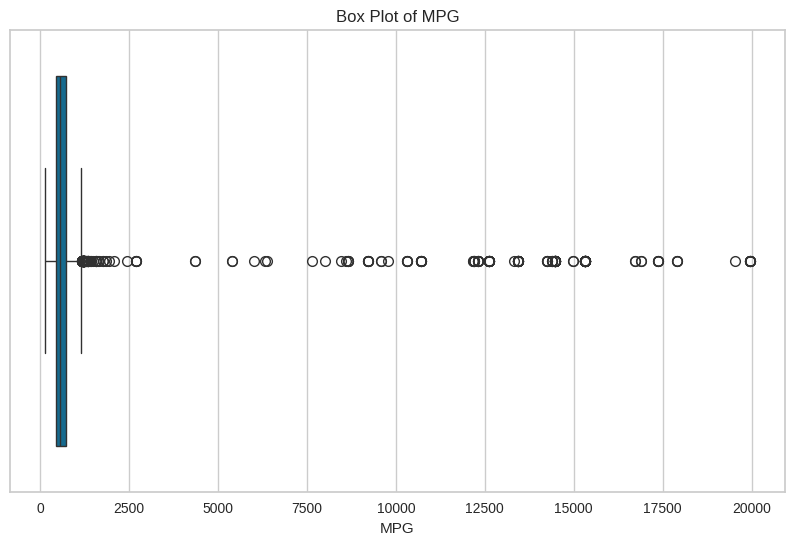

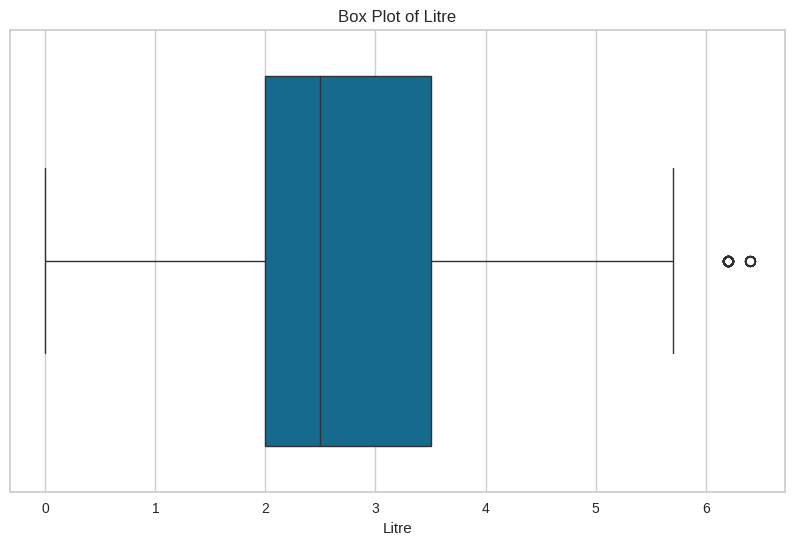

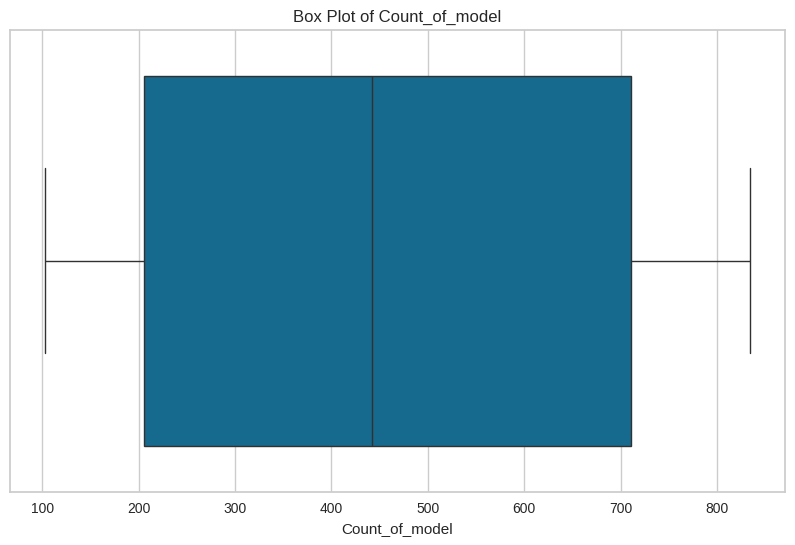

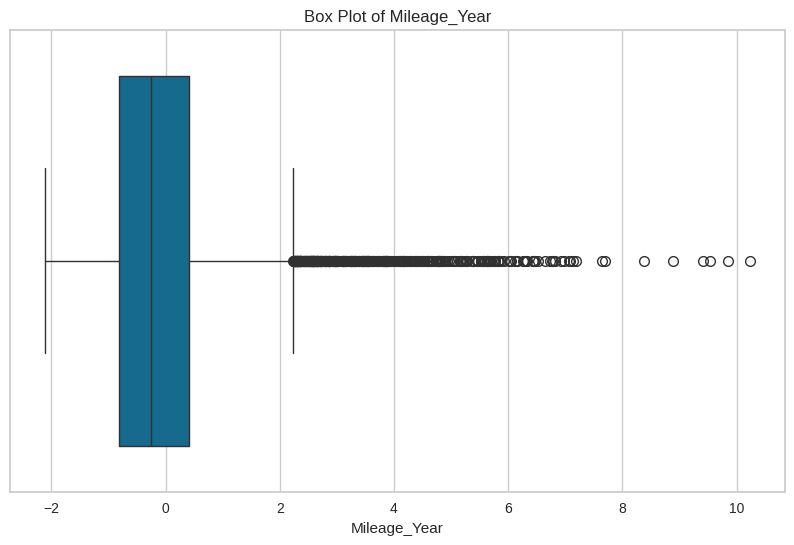

In [ ]:
#outlie durumöarını gözlemlediimizde Sellerreviews'de daha açık görüyoruz
numeric_cols = df.select_dtypes(include=['number']).columns

# Her bir sayısal sütun için box plot oluşturma
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()


In [ ]:
df[df["SellerReviews"]>15000]  # 8 tane değer var. burda drop işlemi yapabiliriz outlier değerler için

Year     Make               Model Used/New   Price  ConsumerReviews  \
581   2020      BMW             X3 M40i     Used  49.999               51   
773   2020      BMW             X3 M40i     Used  51.995               51   
2552  2019    Mazda  CX-9 Grand Touring     Used  33.499               52   
3545  2017      GMC  Sierra 1500 Denali     Used  43.499              187   
4091  2014  Hyundai          Elantra SE     Used  13.999              132   
4323  2019    Honda       Passport EX-L     Used  34.399              102   
7657  2019    Mazda        CX-9 Touring     Used  31.399               52   
7658  2017      GMC  Sierra 1500 Denali     Used  40.995              187   

     SellerType                 SellerName  SellerRating  SellerReviews  \
581      Dealer  Off Lease Only Palm Beach           4.9          27351   
773      Dealer  Off Lease Only Palm Beach           4.9          27351   
2552     Dealer     Off Lease Only Orlando           4.9          27824   
3545     Dealer     Off Lease Only Orlando           4.9          27824   
4091     Dealer     Off Lease Only Orlando           4.9          27824   
4323     Dealer     Off Lease Only Orlando           4.9          27824   
7657     Dealer     Off Lease Only Orlando           4.9          27824   
7658     Dealer     Off Lease Only Orlando           4.9          27824   

                               StreetName State Zipcode DealType  \
581   1200 S Congress Ave West Palm Beach    FL   33406     Good   
773   1200 S Congress Ave West Palm Beach    FL   33406     Fair   
2552              8443 McCoy Road Orlando    FL   32822    Great   
3545              8443 McCoy Road Orlando    FL   32822    Great   
4091              8443 McCoy Road Orlando    FL   32822     Fair   
4323              8443 McCoy Road Orlando    FL   32822     Good   
7657              8443 McCoy Road Orlando    FL   32822    Great   
7658              8443 McCoy Road Orlando    FL   32822    Great   

                ExteriorColor   InteriorColor Drivetrain  FuelType  \
581   Black Sapphire Metallic          Cognac        AWD  Gasoline   
773   Glacier Silver Metallic  Canberra Beige        AWD  Gasoline   
2552   Deep Crystal Blue Mica           Black        FWD  Gasoline   
3545               Onyx Black       Jet Black        4WD  Gasoline   
4091             Venetian Red            Gray        FWD  Gasoline   
4323    Modern Steel Metallic           Black        AWD  Gasoline   
7657    Machine Gray Metallic            Sand        FWD  Gasoline   
7658     Quicksilver Metallic       Jet Black        4WD  Gasoline   

                    VIN    Stock# Transmission_Type Speed_Type  \
581   5UXTY9C06L9B58334   C366396              auto        8.0   
773   5UXTY9C09LLE60218   T355872              auto        8.0   
2552  JM3TCADY5K0312593  P364004B              auto        6.0   
3545  3GTU2PEJXHG442359   O365276              auto        8.0   
4091  5NPDH4AE3EH470559  O366426A              auto        6.0   
4323  5FNYF8H59KB020302   O367745              auto        9.0   
7657  JM3TCACY5K0316161   O367538              auto        6.0   
7658  3GTU2PEJXHG476267  P359710A              auto        8.0   

      weighted_consumer_rating   MPG State_1  Litre Cylindder_Arrangement  \
581                     17.591   567      FL    3.0                    I6   
773                     17.591   567      FL    3.0                    I6   
2552                    18.650   616      FL    2.5                    I4   
3545                    15.548   315      FL    6.2                    V8   
4091                    15.525  1064      FL    1.8                    I4   
4323                    16.866   456      FL    3.5                    V6   
7657                    18.650   616      FL    2.5                    I4   
7658                    15.548   315      FL    6.2                    V8   

      Count_of_model  Mileage_Year  
581              834     -0.546291  
773              834     -0.8

In [212]:
value_counts = df['SellerReviews'].value_counts()

to_drop = value_counts[value_counts < 2].index

# to_drop listesindeki indekslere sahip satırları düşürür
df = df[~df['SellerReviews'].isin(to_drop)]

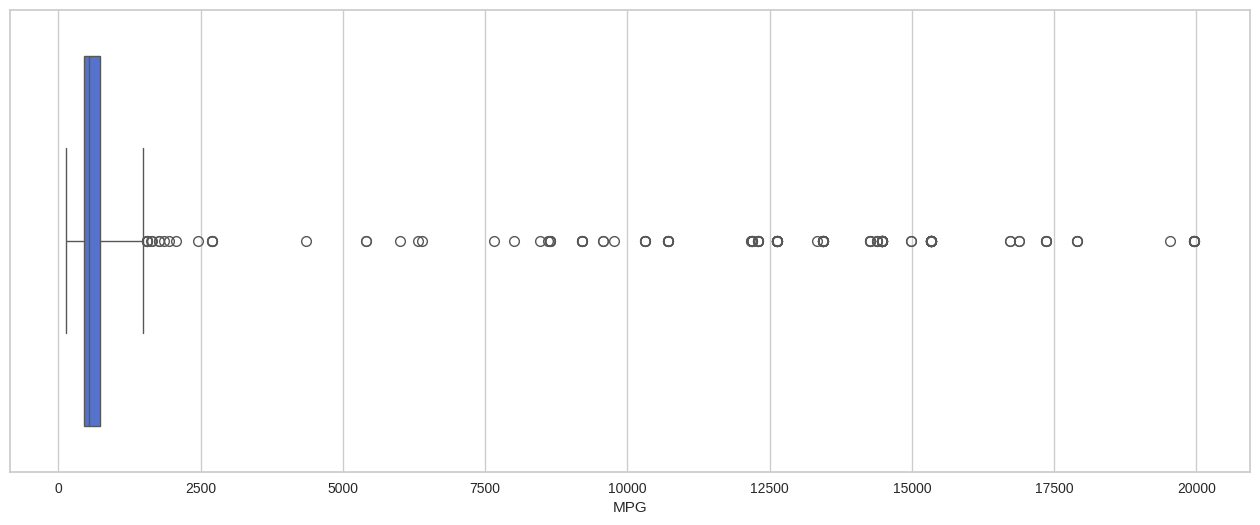

In [47]:
plt.figure(figsize=(16,6))
sns.boxplot(x="MPG", data=df, whis=3, color="royalblue")
plt.show()

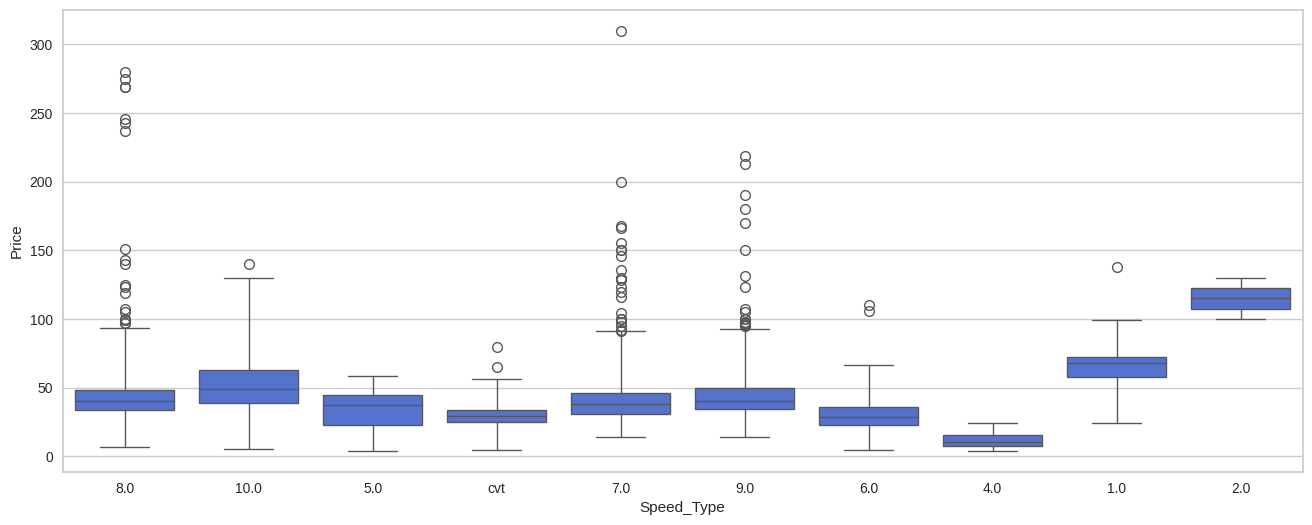

In [ ]:
plt.figure(figsize=(16,6))
sns.boxplot(x="Speed_Type", y="Price", data=df, whis=3, color="royalblue")
plt.show()

In [213]:
df.drop(["Model", "SellerName", "StreetName", "VIN", "Stock#"], axis=1, inplace=True)

# Encode

In [130]:
# kategorik verilerde unique değerlere baktık
for col in df.select_dtypes('object'):
    print(f"{col:<20}:", df[col].nunique())# col<20: çıktının daha okunabilri hale gelmesi için

Make                : 28
Used/New            : 2
SellerType          : 2
State               : 58
Zipcode             : 1963
DealType            : 3
ExteriorColor       : 899
InteriorColor       : 342
Drivetrain          : 4
FuelType            : 5
Transmission_Type   : 3
Speed_Type          : 10
State_1             : 23
Cylindder_Arrangement: 10


In [50]:
df["SellerType"].value_counts()  # burda baya yetersiz bir durum söz konusu öğrenmesi için pek sağlıklı değil

SellerType
Dealer     7794
Private      22
Name: count, dtype: int64

In [51]:
df.FuelType.value_counts() #7bine karşı diğerleri...

FuelType
Gasoline     7483
Electric      135
Flex Fuel     101
Hybrid         63
Diesel         34
Name: count, dtype: int64

In [121]:
df[df.Speed_Type == "1"]

Year     Make Used/New   Price  ConsumerReviews SellerType  \
146   2020    Tesla     Used  65.995               10     Dealer   
154   2021    Tesla     Used  71.277               15     Dealer   
160   2020    Tesla     Used  73.992               10     Dealer   
181   2021    Tesla     Used  65.786                1     Dealer   
257   2021    Tesla     Used  74.799               15     Dealer   
...    ...      ...      ...     ...              ...        ...   
8021  2018    Tesla     Used  76.498               15     Dealer   
8023  2019  Hyundai     Used  31.975               13     Dealer   
8120  2020    Tesla     Used  64.990               10     Dealer   
8156  2018    Tesla     Used  82.350               15     Dealer   
8258  2019    Tesla     Used  54.998               33     Dealer   

      SellerRating  SellerReviews State Zipcode DealType       ExteriorColor  \
146            3.4            472    NY   10475    Great                Blue   
154            4.8           3306    NH   03103     Good   Pearl White Multi   
160            4.6            143    CA   95020     Good               White   
181            4.5             62    TX   75070     Good   Pearl White Multi   
257            4.7            507    TX   78230     Good   Pearl White Multi   
...            ...            ...   ...     ...      ...                 ...   
8021           4.5            166    CA   94560     Good     Silver Metallic   
8023           4.8           1105    AZ   85284     Good       Galactic Gray   
8120           4.4            333    TX   75006     Good               Black   
8156           4.9           3110    MD   20879     Fair  Deep Blue Metallic   
8258           4.8            944    DE   19806     Good           Red Multi   

      InteriorColor Drivetrain  FuelType Transmission_Type Speed_Type  \
146               –        AWD  Electric              auto          1   
154   White / Black        AWD  Electric              auto          1   
160   White / Black        AWD  Electric              auto          1   
181   White / Black        AWD  Gasoline              auto          1   
257   White / Black        AWD  Electric              auto          1   
...             ...        ...       ...               ...        ...   
8021          Black        AWD  Electric              auto          1   
8023          Black        FWD  Electric              auto          1   
8120          Black        AWD  Electric              auto          1   
8156          Black        AWD  Electric              auto          1   
8258          Black        RWD  Electric              auto          1   

      weighted_consumer_rating    MPG State_1  Litre Cylindder_Arrangement  \
146                     10.350  14478      NY    0.0              Electric   
154                     11.042  15327   Other    0.0              Electric   
160                     10.350  14478      CA    0.0              Electric   
181                      2.300  12626      TX    0.0                   V10   
257                     11.042  12190      TX    0.0              Electric   
...                        ...    ...     ...    ...                   ...   
8021                    13.691   8645      CA    0.0              Electric   
8023                    17.568  14256      AZ    0.0              Electric   
8120                    10.350  14478      TX    0.0              Electric   
8156                    13.691   7654      MD    0.0              Electric   
8258                    18.270  16728   Other    0.0              Electric   

      Count_of_model  dt_4WD  dt_AWD  dt_FWD  dt_RWD  dt_Diesel  dt_Electric  \
146              142       0       1       0       0          0            1   
154              142       0       1       0       0          0            1   
160              142       0       1       0       0          0            1   
181              142       0       1       0       0          0            0   
257           

In [214]:
df = df.join(df["Drivetrain"].str.get_dummies().add_prefix("dt_"))
df = df.join(df["FuelType"].str.get_dummies().add_prefix("ft_"))
df = df.join(df["Make"].str.get_dummies().add_prefix("mk_"))
df = df.join(df["Cylindder_Arrangement"].str.get_dummies().add_prefix("ca_"))
df = df.join(df["Speed_Type"].str.get_dummies().add_prefix("sp_"))
df = df.join(df["State_1"].str.get_dummies().add_prefix("st_"))




In [215]:
label_encoder = LabelEncoder()

columns_to_encode = ['Used/New', 'SellerType', "Transmission_Type", "DealType"]

for col in columns_to_encode:
    df[col] = label_encoder.fit_transform(df[col])

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7822 entries, 0 to 8278
Columns: 104 entries, Year to st_WA
dtypes: float64(5), int64(89), object(10)
memory usage: 6.5+ MB


In [218]:
df.head(1)

Year    Make  Used/New   Price  ConsumerReviews  SellerType  SellerRating  \
0  2019  Toyota         1  39.998               45           0           3.3   

   SellerReviews State Zipcode  DealType ExteriorColor InteriorColor  \
0              3    CA   92562         2           Red         Black   

  Drivetrain  FuelType  Transmission_Type Speed_Type  \
0        FWD  Gasoline                  0        8.0   

   weighted_consumer_rating  MPG State_1  Litre Cylindder_Arrangement  \
0                    15.856  513      CA    3.5                    V6   

   Count_of_model  Mileage_Year  dt_4WD  dt_AWD  dt_FWD  dt_RWD  ft_Diesel  \
0             711     -0.301129       0       0       1       0          0   

   ft_Electric  ft_Flex Fuel  ft_Gasoline  ft_Hybrid  mk_Acura  mk_Audi  \
0            0             0            1          0         0        0   

   mk_BMW  mk_Buick  mk_Cadillac  mk_Chevrolet  mk_Dodge  mk_Ford  mk_GMC  \
0       0         0            0             0         0        0       0   

   mk_Honda  mk_Hyundai  mk_INFINITI  mk_Jeep  mk_Kia  mk_Land  mk_Lexus  \
0         0           0            0        0       0        0         0   

   mk_Lincoln  mk_Mazda  mk_Mercedes-Benz  mk_Nissan  mk_Other  mk_Porsche  \
0           0         0                 0          0         0           0   

   mk_RAM  mk_Subaru  mk_Tesla  mk_Toyota  mk_Volkswagen  mk_Volvo  ca_H4  \
0       0          0         0          1              0         0      0   

   ca_H6  ca_I3  ca_I4  ca_I5  ca_I6  ca_V10  ca_V6  ca_V8  ca_electric  sp_0  \
0      0      0      0      0      0       0      1      0            0     0   

   sp_1.0  sp_10.0  sp_2.0  sp_4.0  sp_5.0  sp_6.0  sp_7.0  sp_8.0  sp_9.0  \
0       0        0       0       0       0       0       0       1       0   

   st_AZ  st_CA  st_CO  st_FL  st_GA  st_IL  st_IN  st_MA  st_MD  st_MI  \
0      0      1      0      0      0      0      0      0      0      0   

   st_MN  st_MO  st_NC  st_NJ  st_NY  st_OH  st_Other  st_PA  st_SC  st_TN  \
0      0      0      0      0      0      0         0      0      0      0   

   st_TX  st_VA  st_WA  
0      0      0      0

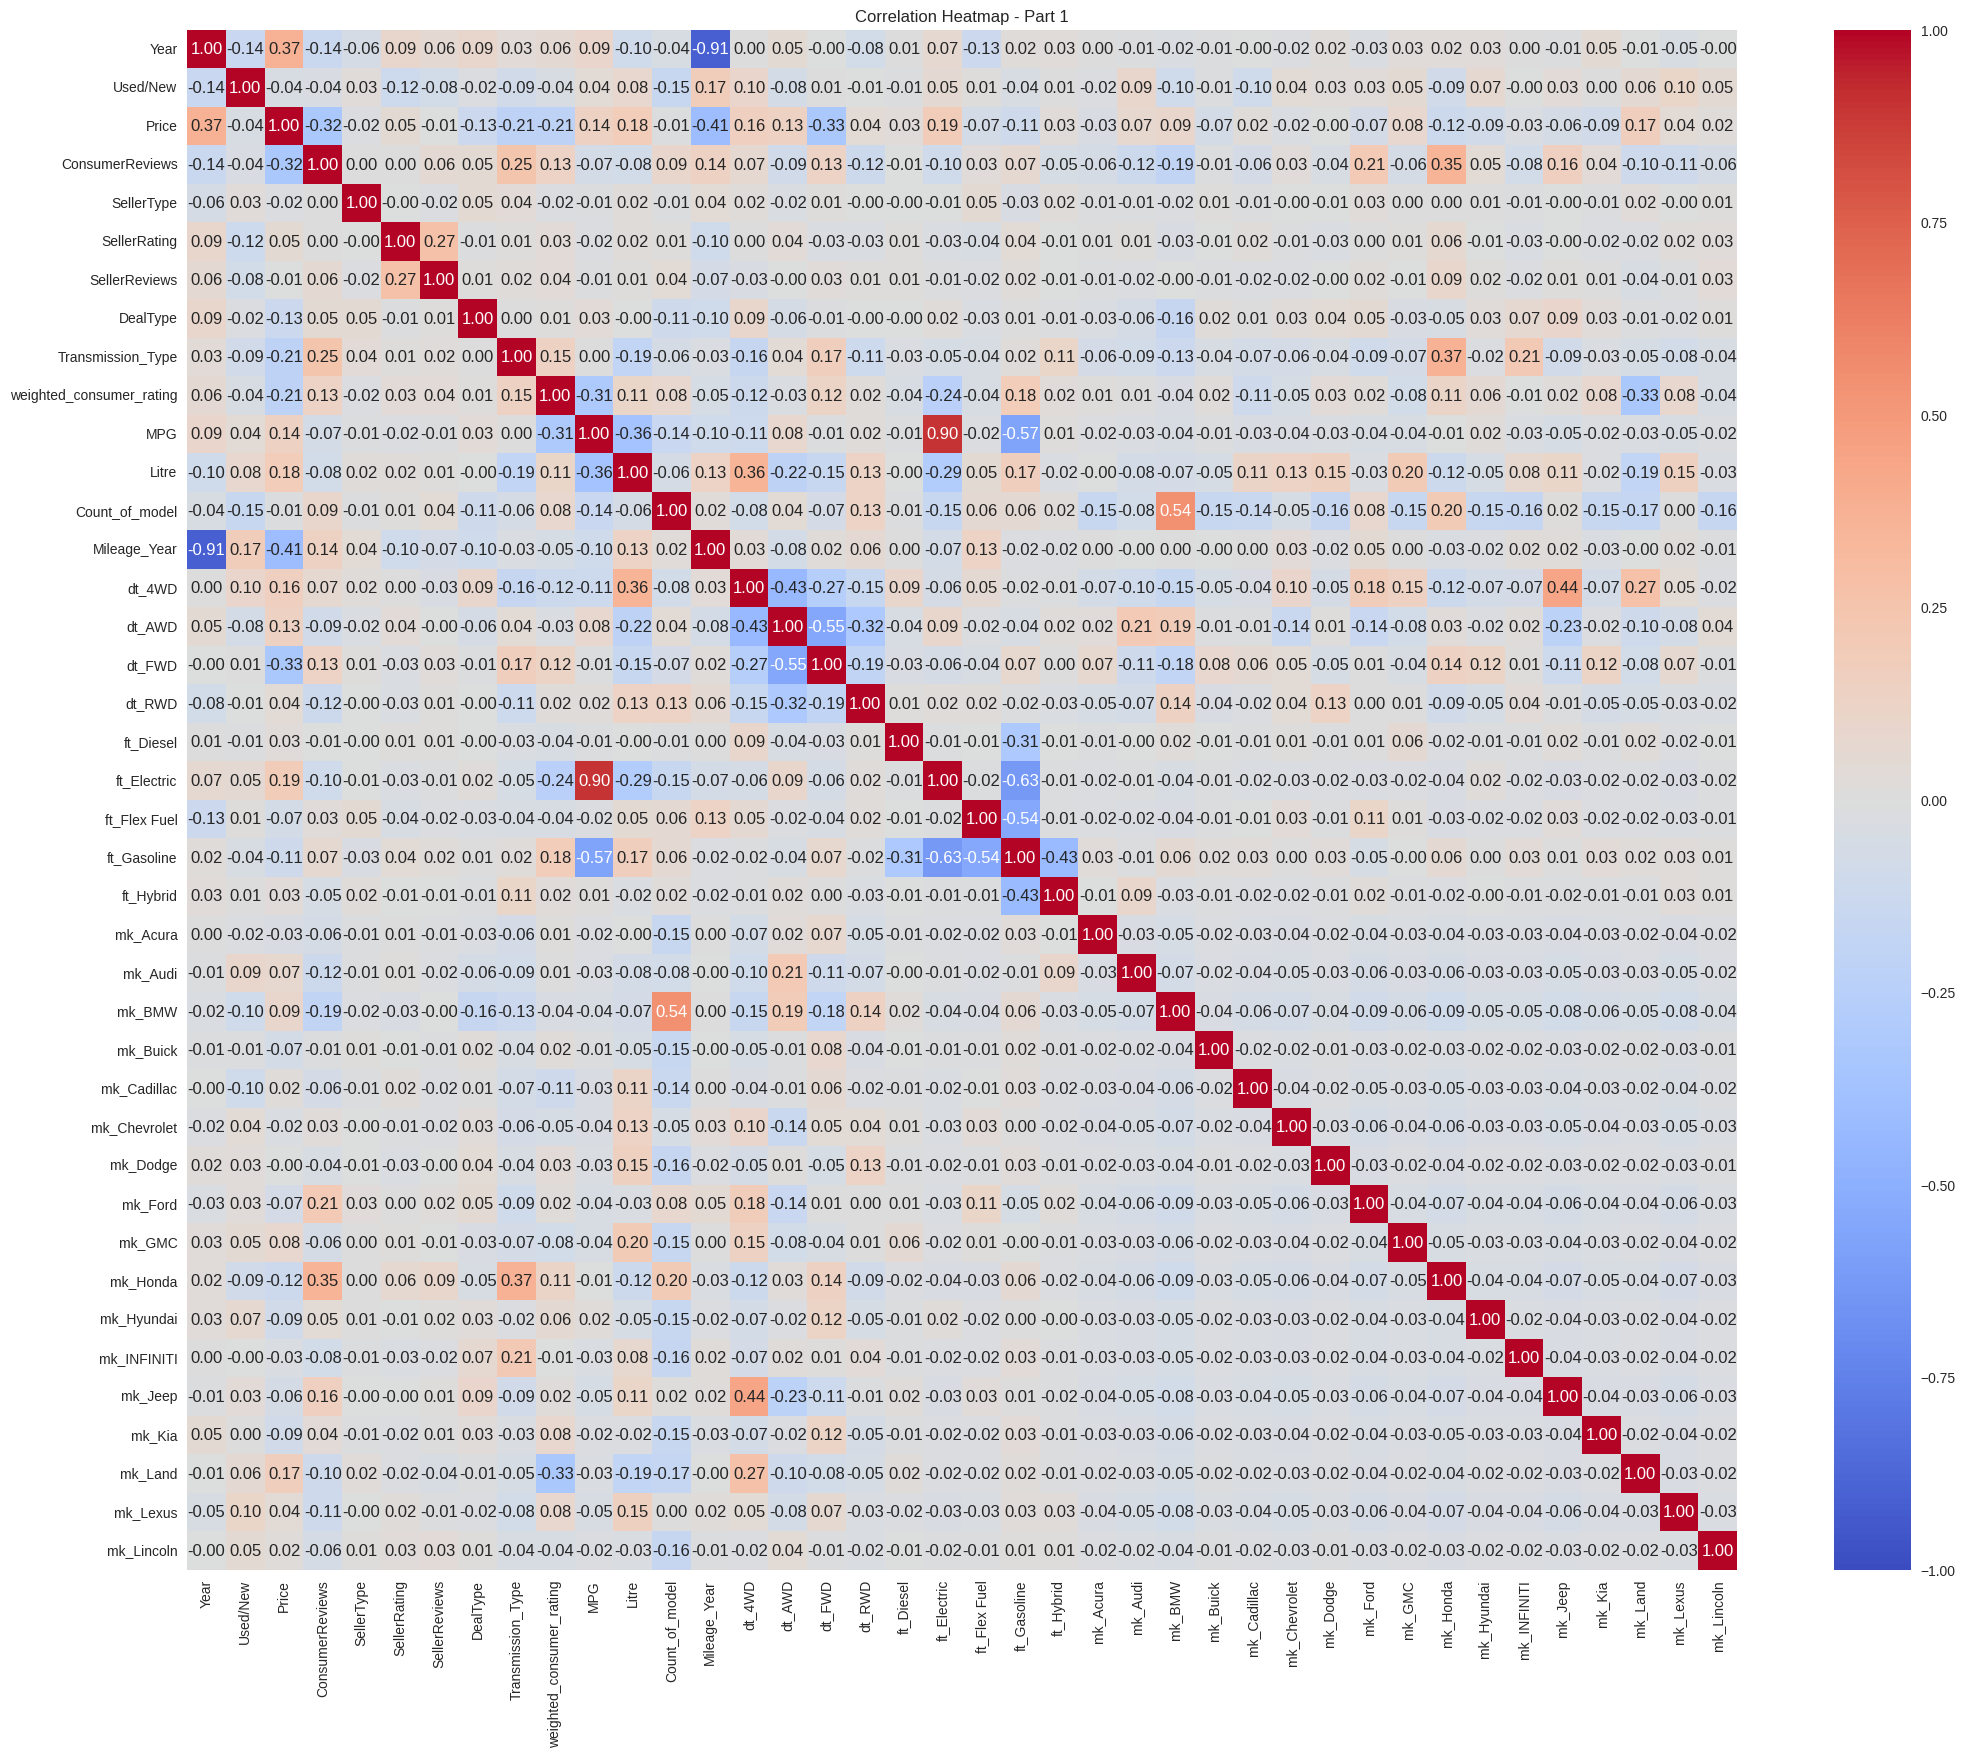

In [53]:
numeric_df = df.select_dtypes(include=['number'])

cols_part1 = numeric_df.columns[:40]  # First 40 columns
#cols_part2 = numeric_df.columns[40:]  # Remaining columns

plt.figure(figsize=(25, 20))
sns.heatmap(df[cols_part1].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Part 1')
plt.show()


In [55]:
df.drop(["ca_nothing"],  axis=1, inplace=True)

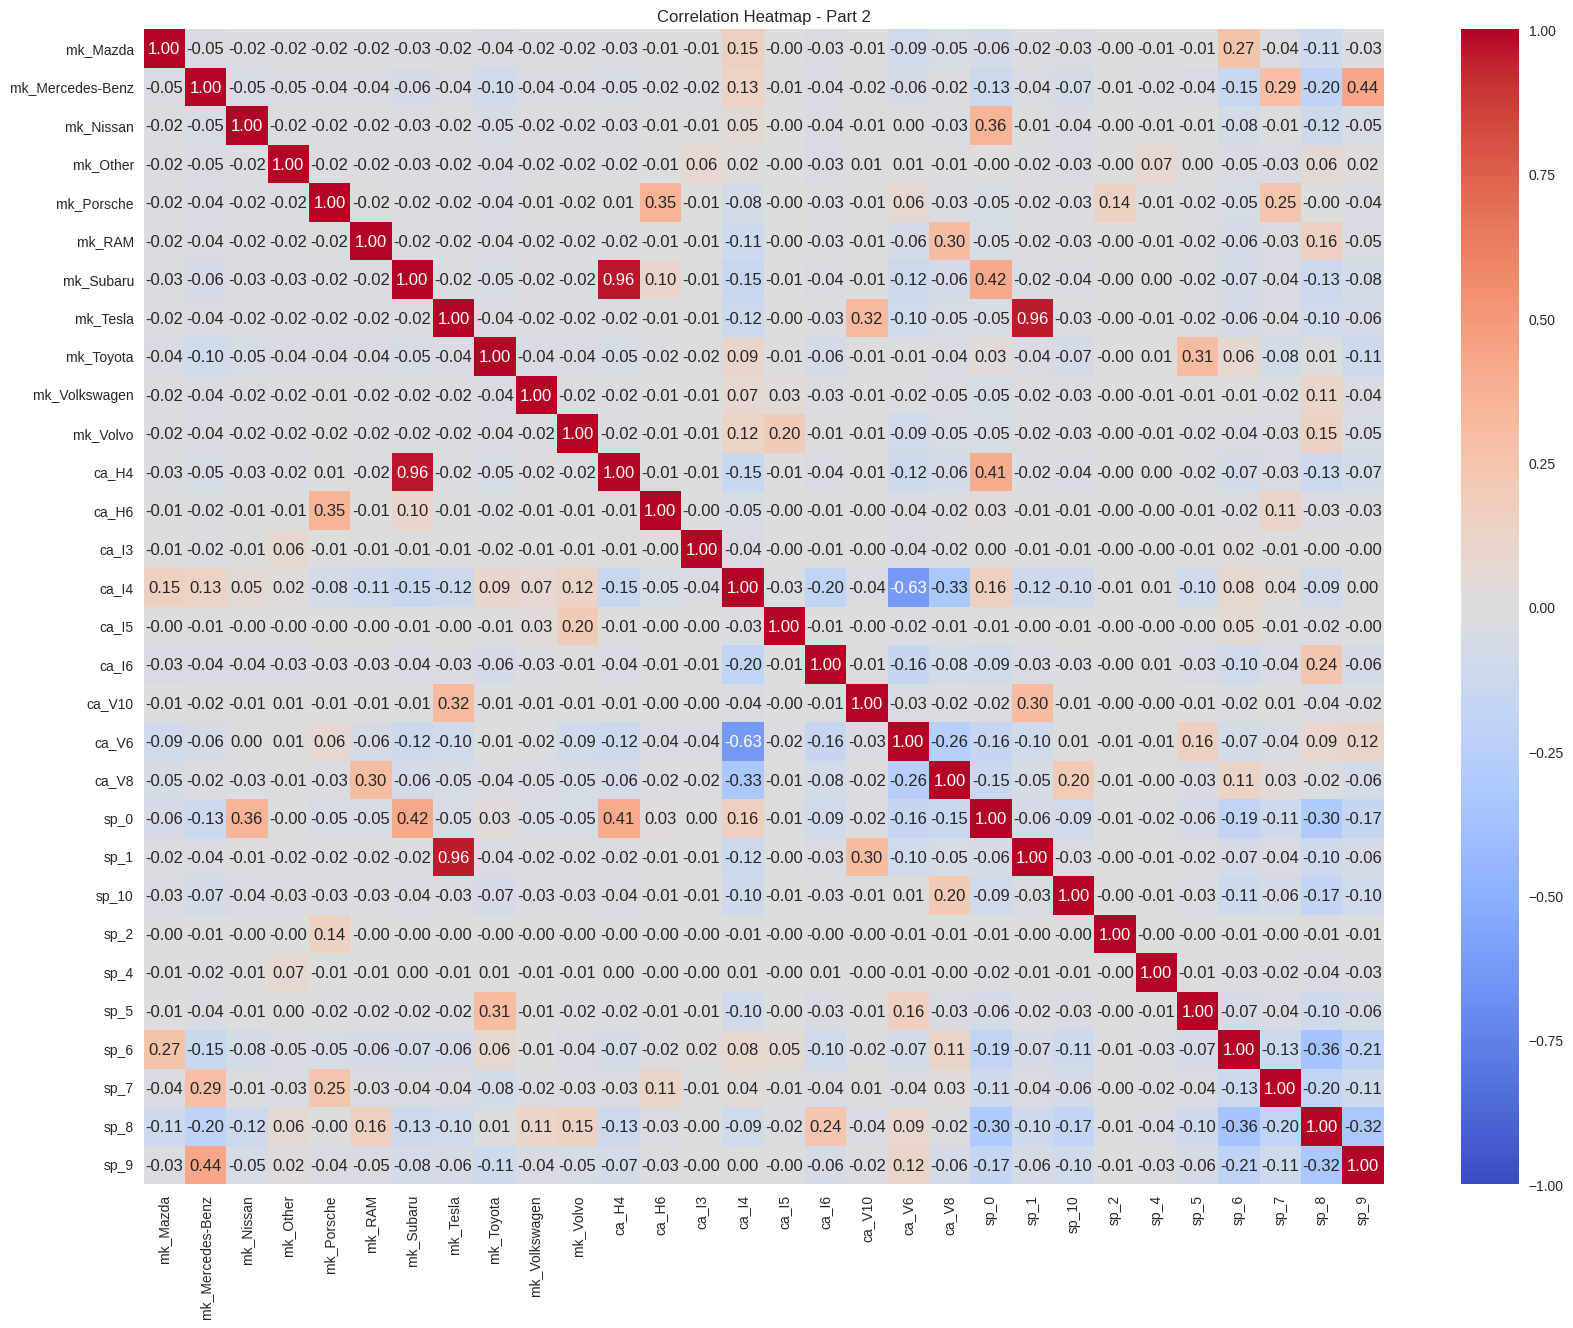

In [56]:
numeric_df = df.select_dtypes(include=['number'])

cols_part2 = numeric_df.columns[40:]  # Remaining columns

plt.figure(figsize=(20, 15))
sns.heatmap(df[cols_part2].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Part 2')
plt.show()

In [111]:
df.Transmission_Type.value_counts

Transmission_Type
auto     6707
cvt      1078
other      31
Name: count, dtype: int64

In [219]:
df.drop(["Year", "Drivetrain", "FuelType","Zipcode","Make","Cylindder_Arrangement", "State", "ExteriorColor", "InteriorColor","Speed_Type"], axis=1, inplace=True)

In [75]:
pip install featurewiz


In [77]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 33.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [69]:
from featurewiz import FeatureWiz
X = df.drop(columns='Price')
y = df['Price']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Featurewiz nesnesini oluşturma ve yapılandırma
wiz = FeatureWiz(feature_engg='',  # Özellik mühendisliği tekniklerini belirtmek isterseniz ekleyebilirsiniz
                nrows=None,  # Kullanılacak satır sayısı, None ise tüm veri kullanılır
                transform_target=True,  # Hedef değişkeni dönüştürme
                category_encoders='auto',  # Kategorik değişkenler için kodlayıcı yöntemi
                auto_encoders='VAE',  # Otomatik kodlayıcı tipi (VAE: Değişkenli Otoenkoder)
                ae_options={},  # Otoenkoder seçenekleri
                add_missing=False,  # Eksik değer göstergesi eklemek
                imbalanced=False,  # Veri seti dengesiz mi?
                verbose=0)  # Ayrıntı düzeyi

# Eğitim setinde fit_transform() yöntemini kullanarak özellikleri uygulama
X_train_selected, y_train = wiz.fit_transform(X_train, y_train)

# Test setinde transform() yöntemini kullanarak aynı özellikleri uygulama
X_test_selected = wiz.transform(X_test)

# Seçilen özellikleri almak için features özniteliğini kullanma (isteğe bağlı)
selected_features = wiz.features

featurewiz is given 0.9 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
Since Auto Encoders are selected for feature extraction,
    SULOV is skipped since auto-encoders is given...
    Recursive XGBoost is also skipped...
VariationalAutoEncoder()
    AE dictionary given: dict_items([])
    final list of scalers given: [minmax]
Loaded input data. Shape = (6257, 68)
#### Starting featurewiz transform for train data ####
    Regression models don't need targets to be transformed to numeric...
    Single_Label Regression problem 
Shape of dataset: (6257, 68). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (6257, 68)
Performing hyper param selection fo

ValueError: 
All the 54 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/featurewiz/auto_encoders.py", line 667, in fit
    self.vae, self.encoder, self.decoder = self._build_model()
  File "/usr/local/lib/python3.10/dist-packages/featurewiz/auto_encoders.py", line 642, in _build_model
    reconstruction_loss = mse(K.flatten(original_inputs), K.flatten(outputs))
  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/backend.py", line 881, in flatten
    return tf.reshape(x, [-1])
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/weak_tensor_ops.py", line 88, in wrapper
    return op(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/common/keras_tensor.py", line 91, in __tf_tensor__
    raise ValueError(
ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```



In [59]:
df.isnull().any().any()


False

In [220]:
corr_by_price = df.corr()["Price"].sort_values()[:-1]
corr_by_price

Mileage_Year      -0.413238
ca_I4             -0.349906
dt_FWD            -0.325201
ConsumerReviews   -0.324117
sp_6.0            -0.255922
                     ...   
mk_Tesla           0.203544
ca_H6              0.219254
sp_10.0            0.220220
mk_Porsche         0.220821
ca_V8              0.326867
Name: Price, Length: 92, dtype: float64

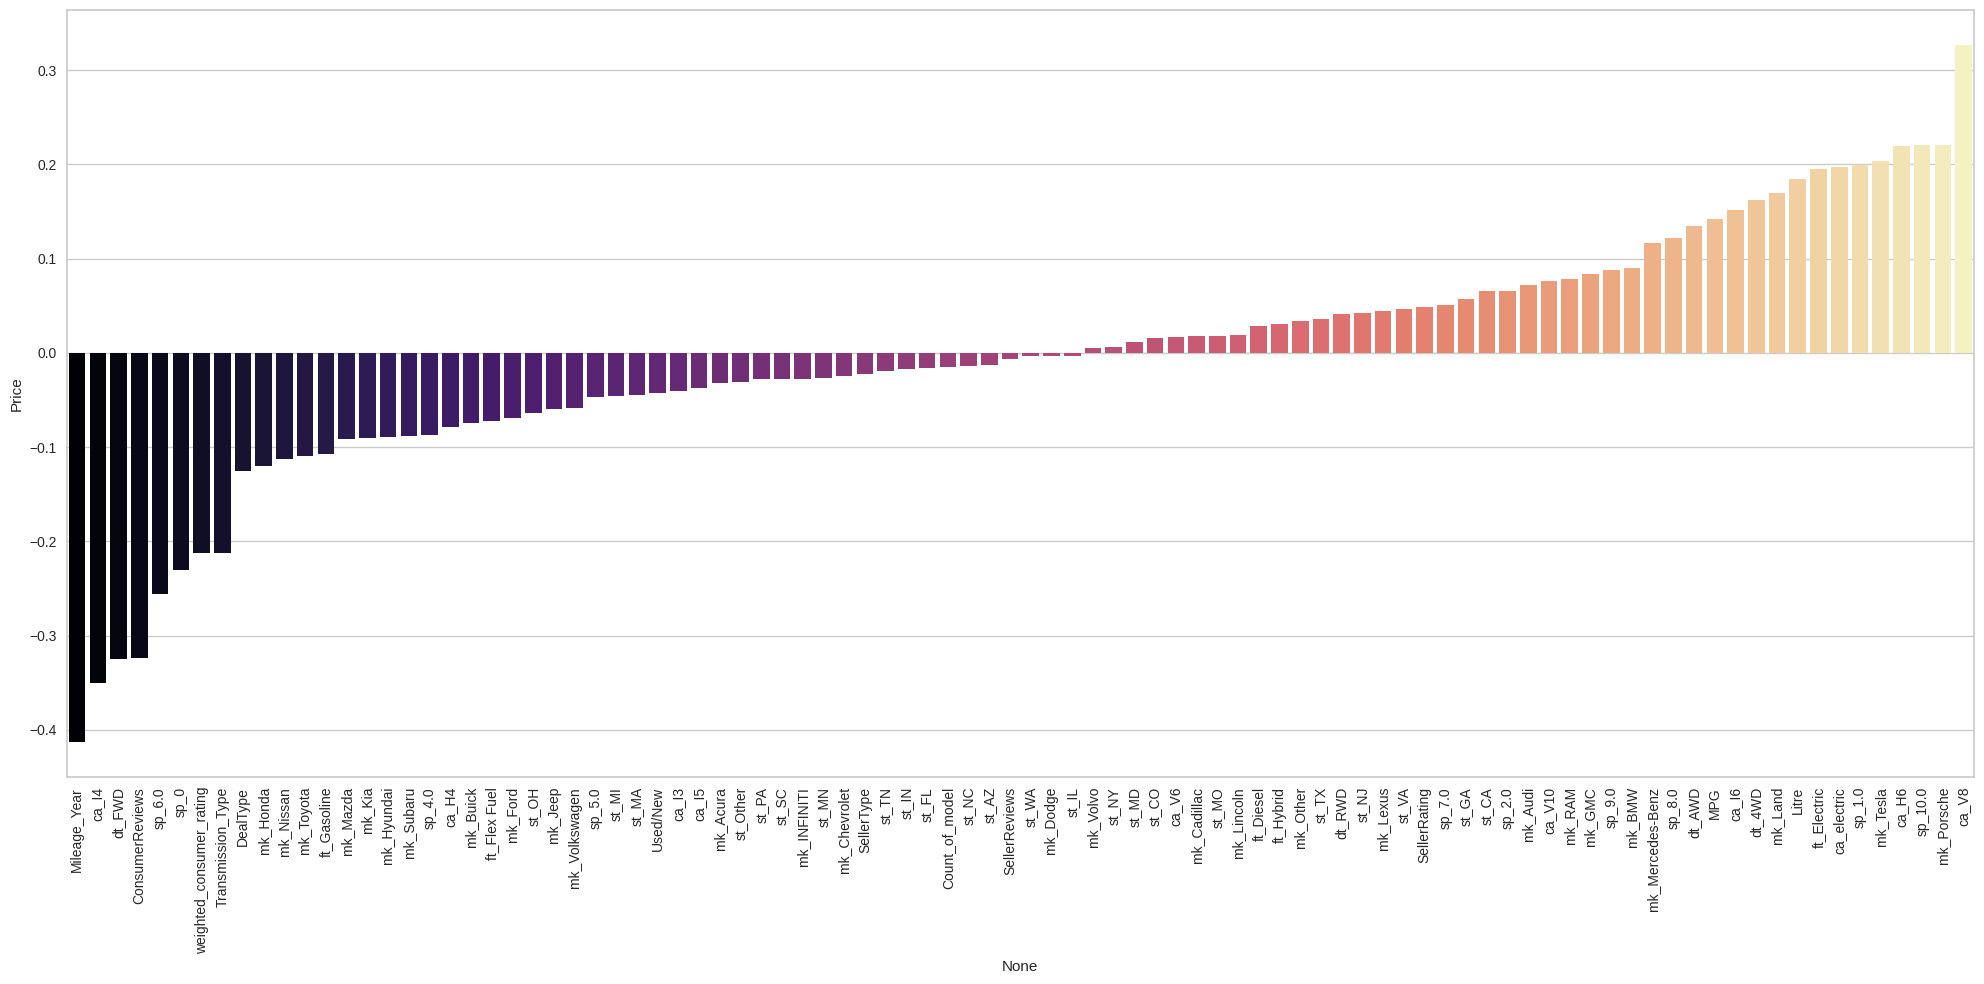

In [221]:
plt.figure(figsize = (20,10))
sns.barplot(x = corr_by_price.index, y = corr_by_price, palette="magma")
plt.xticks(rotation=90)
plt.tight_layout();


# Lazy Predict

In [ ]:
pd.set_option('display.max_columns', None)

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

# Train - Test

### encode işelmelrini X ğzerinden alıp yapabilrisin daha düzelidir

In [232]:
X= df.drop(columns="Price")
y= df.Price


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [234]:
X_train.shape

(6257, 92)

In [235]:
X_test.shape

(1565, 92)

In [226]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [227]:
def train_val(model, X_train, y_train, X_test, y_test):

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    scores = {
        "train": {
            "R2": r2_score(y_train, y_train_pred),
            "MAE": mean_absolute_error(y_train, y_train_pred),
            "MSE": mean_squared_error(y_train, y_train_pred),
            "RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
            "MAPE": mean_absolute_percentage_error(y_train, y_train_pred)
        },
        "test": {
            "R2": r2_score(y_test, y_pred),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred)
        }
    }

    return pd.DataFrame(scores)

# outlier değerlerlden kurtulduk

In [246]:
df1 = df[~(df.Price>80.000)]  #sadece bunlara değilde tüm featurlara bakabilirsin.
#feature selction= getdummies'ten sonra bakabilirsin. mi(bilgi kazancı), featureviz(kütüphane)

In [247]:
X = df1.drop(columns = "Price")
y = df1.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# LightGBM

In [248]:
from lightgbm import LGBMRegressor


In [249]:
operations = [("LGBM_model", LGBMRegressor(random_state=101, objective='regression'))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 6117, number of used features: 87
[LightGBM] [Info] Start training from score 38.111796


Pipeline(steps=[('LGBM_model',
                 LGBMRegressor(objective='regression', random_state=101))])

In [250]:
train_val(pipe_model, X_train, y_train, X_test, y_test)


train       test
R2    0.950138   0.915415
MAE   2.202619   2.727727
MSE   8.901772  16.314758
RMSE  2.983584   4.039153
MAPE  6.477124   7.854039

In [251]:
operations = [("LGBM_model",
               LGBMRegressor(random_state=101, objective='regression'))]

model = Pipeline(steps=operations)
scores = cross_validate(model,
                        X_train,
                        y_train,
                        scoring=[
                            'r2', 'neg_mean_absolute_error',
                            'neg_mean_squared_error',
                            'neg_root_mean_squared_error'
                        ],
                        cv=10,
                        return_train_score=True)

pd.DataFrame(scores).mean()[2:]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 5505, number of used features: 85
[LightGBM] [Info] Start training from score 38.160986
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 5505, number of used features: 86
[LightGBM] [Info] Start training from score 38.103755
[LightGBM] [Warning] Found w

test_r2                               0.905050
train_r2                              0.951783
test_neg_mean_absolute_error         -2.888316
train_neg_mean_absolute_error        -2.169752
test_neg_mean_squared_error         -16.902671
train_neg_mean_squared_error         -8.608235
test_neg_root_mean_squared_error     -4.108769
train_neg_root_mean_squared_error    -2.933902
dtype: float64

In [ ]:
param_grid = {
    'LGBM_model__learning_rate': [0.01, 0.05, 0.1],
    'LGBM_model__n_estimators': [100, 200, 500],
    'LGBM_model__max_depth': [3, 5, 8],
    "LGBM_model__num_leaves": [8, 32, 256],  # 2^max_depth'e uygun değerler ikinin maxdepth kuvvetini al demek.
    'LGBM_model__subsample': [0.8, 1.0],
    'LGBM_model__colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
operations = [("LGBM_model", LGBMRegressor(random_state=101, objective='regression', verbose=-1))]

model = Pipeline(steps=operations)

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1,
                          return_train_score=True).fit(X_train, y_train)

In [ ]:
grid_model.best_params_


{'LGBM_model__colsample_bytree': 0.8,
 'LGBM_model__learning_rate': 0.1,
 'LGBM_model__max_depth': 5,
 'LGBM_model__n_estimators': 500,
 'LGBM_model__num_leaves': 32,
 'LGBM_model__subsample': 0.8}

In [ ]:
grid_model.best_score_


-3.8026226279607243

In [ ]:
train_val(grid_model, X_train, y_train, X_test, y_test)

train       test
R2    0.970459   0.918769
MAE   1.711386   2.619934
MSE   5.441369  13.801058
RMSE  2.332674   3.714978
MAPE  4.967295   7.712505

# Featurewiz

In [257]:
import featurewiz as gwiz



In [258]:
wiz =gwiz.FeatureWiz(verbose=1)



featurewiz is given 0.9 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['label', 'label']
    final list of scalers given: []


Loaded input data. Shape = (6117, 92)
    selecting 92 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Regression problem 
Shape of dataset: (6117, 92). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 4, int_vars = 88, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
label encoder selected for transforming all categorical variables
Using My_LabelEncoder() and My_LabelEncoder() as encoders
    alert: there is no scaler specified. Options are: max, std, robust, maxabs.
    no other vars left in dataset to transform...
Time taken to define data pipeline = 1 second(s)
No model input given...
Lazy Transformer Pipeline created...
    Tim

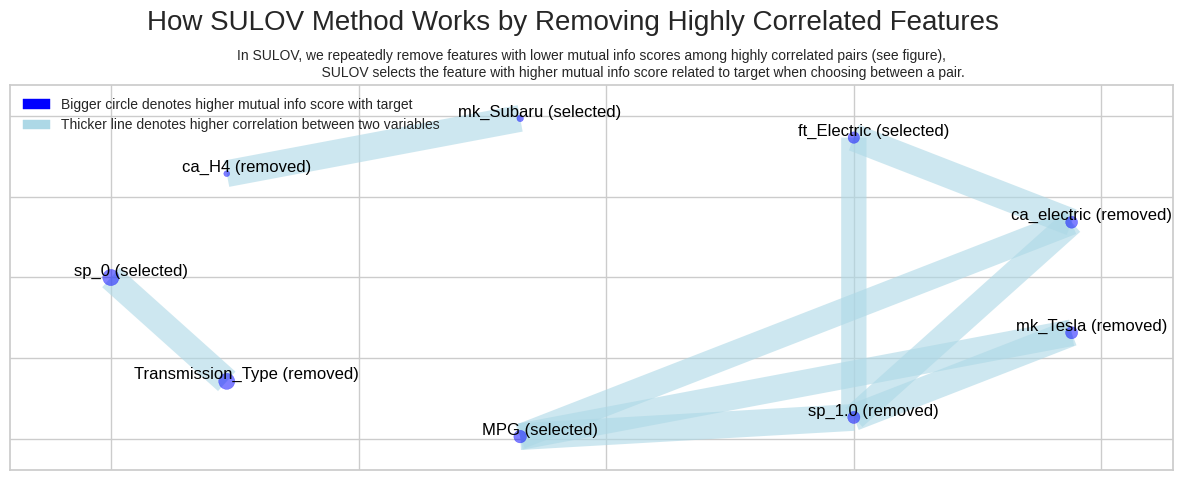

Performing recursive XGBoost feature selection from 86 features...
    Taking top 17 features per iteration...
    Number of booster rounds = 100
        Selected: ['Mileage_Year', 'ConsumerReviews', 'MPG', 'ca_I4', 'Litre', 'weighted_consumer_rating', 'Count_of_model', 'dt_FWD', 'DealType', 'sp_6.0', 'sp_0', 'ca_V6', 'sp_10.0', 'SellerReviews', 'mk_Lexus', 'ca_V8', 'mk_Dodge']
        Selected: ['Mileage_Year', 'MPG', 'ca_I4', 'Litre', 'weighted_consumer_rating', 'sp_6.0', 'sp_0', 'ca_I6', 'sp_10.0', 'mk_Mercedes-Benz', 'ca_V6', 'SellerRating', 'mk_Lexus', 'ca_V8', 'mk_Land', 'mk_Ford', 'mk_Porsche']
        Selected: ['Mileage_Year', 'MPG', 'ca_I4', 'Litre', 'weighted_consumer_rating', 'sp_6.0', 'sp_0', 'ca_I6', 'sp_10.0', 'ca_V6', 'SellerRating', 'sp_8.0', 'sp_9.0', 'mk_Porsche', 'ca_V8', 'ca_I3', 'mk_Volkswagen']
        Selected: ['MPG', 'Mileage_Year', 'Litre', 'weighted_consumer_rating', 'sp_6.0', 'sp_0', 'SellerRating', 'sp_8.0', 'sp_9.0', 'sp_7.0', 'st_FL', 'st_GA', 'st_MI', '

In [261]:
X_train_s, y_train = wiz.fit_transform(X_train, y_train)

X_test_s = wiz.transform(X_test)




In [262]:
operations = [("LGBM_model", LGBMRegressor(random_state=101, objective='regression'))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train_s, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 6117, number of used features: 43
[LightGBM] [Info] Start training from score 38.111796


Pipeline(steps=[('LGBM_model',
                 LGBMRegressor(objective='regression', random_state=101))])

In [264]:
X_train_s

Mileage_Year  ConsumerReviews   MPG  ca_I4  Litre  \
281      -0.111340                5   513      0    3.0   
2609      0.037801              275  1102      1    1.5   
4078      0.039021               87   720      1    2.0   
6713     -0.507127               40   726      1    2.0   
4855     -0.413056               10   374      0    3.0   
...            ...              ...   ...    ...    ...   
646      -0.573227               49   660      1    2.0   
6149      0.230968              224   450      0    3.6   
1467     -0.361932               52   520      1    2.5   
1665     -0.448726              201   456      0    5.7   
5358     -1.245711               79   418      0    5.0   

      weighted_consumer_rating  Count_of_model  dt_FWD  DealType  sp_6.0  \
281                  17.570000             736       0         1       0   
2609                 17.934000             616       1         2       1   
4078                 16.215000             190       0         1       0   
6713                 16.245001             736       0         1       0   
4855                 18.299999             736       0         1       0   
...                        ...             ...     ...       ...     ...   
646                  17.598000             127       0         2       0   
6149                 16.896000             457       0         2       0   
1467                 18.650000             172       0         2       1   
1665                 16.573999             135       0         1       0   
5358                 16.573999             518       0         0       0   

      sp_0  ca_V6  sp_10.0  SellerReviews  mk_Lexus  ca_V8  mk_Dodge  ca_I6  \
281      0      1        0            180         0      0         0      0   
2609     0      0        0            100         0      0         0      0   
4078     1      0        0           1698         0      0         0      0   
6713     0      0        0             34         0      0         0      0   
4855     0      1        0           1660         0      0         0      0   
...    ...    ...      ...            ...       ...    ...       ...    ...   
646      0      0        0            554         0      0         0      0   
6149     0      1        0            332         0      0         0      0   
1467     0      0        0            848         0      0         0      0   
1665     0      0        1            571         0      1         0      0   
5358     0      0        1            757         0      1         0      0   

      mk_Mercedes-Benz  SellerRating  mk_Land  mk_Ford  mk_Porsche  sp_8.0  \
281                  1           4.6        0        0           0       0   
2609                 0           4.2        0        0           0       0   
4078                 0           4.8        0        0           0       0   
6713                 1           4.9        0        0           0       0   
4855                 1           4.7        0        0           0       0   
...                ...           ...      ...      ...         ...     ...   
646                  0           4.7        0        0           0       1   
6149                 0           3.9        0        0           0       1   
1467                 0           4.7        0        0           0       0   
1665                 0           4.1        0        0           0       0   
5358                 0           4.9        0        1           0       0   

      sp_9.0  ca_I3  mk_Volkswagen  sp_7.0  st_FL  st_GA  st_MI  st_CA  \
281        1      0              0       0      0      0      0      0   
2609       0      0              0       0      0      0      0      0   
4078       0      0              0       0      0      0      0      0   
6713       1      0              0       0      0      0      0      0   
4855       1      0              0       0      0      0      0      1   
...      ...    ...            ...     ...    ...    .

In [269]:
train_val(pipe_model, X_train_s, y_train, X_test_s, y_test)

train       test
R2    0.947787   0.908753
MAE   2.258303   2.839920
MSE   9.321509  17.599765
RMSE  3.053115   4.195207
MAPE  6.642047   8.238087

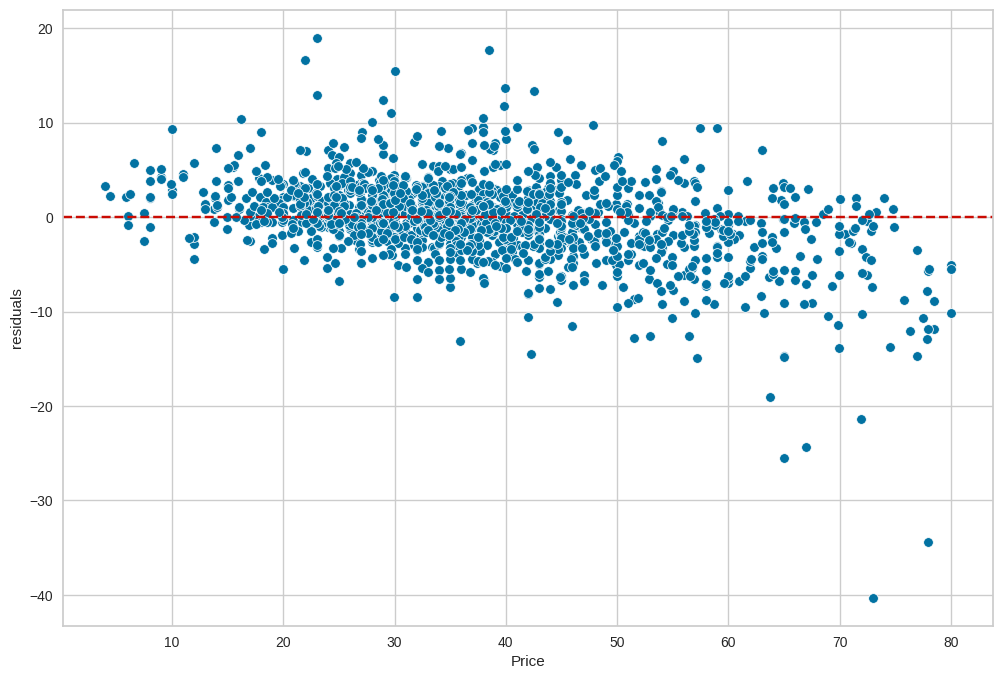

In [272]:
plt.figure(figsize=(12,8))
y_pred = pipe_model.predict(X_test_s)
residuals = y_test-y_pred

sns.scatterplot(x = y_test, y = -residuals) #-residuals
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()


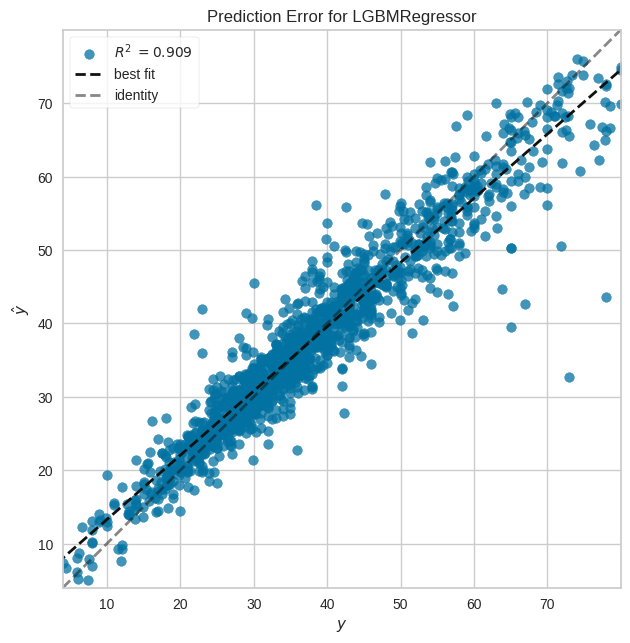

In [275]:
visualizer = RadViz(size=(720, 3000))
visualizer = PredictionError(pipe_model)
visualizer.fit(X_train_s, y_train)
visualizer.score(X_test_s, y_test)
visualizer.show();
#Ortadaki çizgi mükemmel olandır. ama. bu iki çizgiyi birbirne yakınlaştırmaktır.
#burdan outlier tespiti de yaparız ve görürüz hataya sebep var mı diye

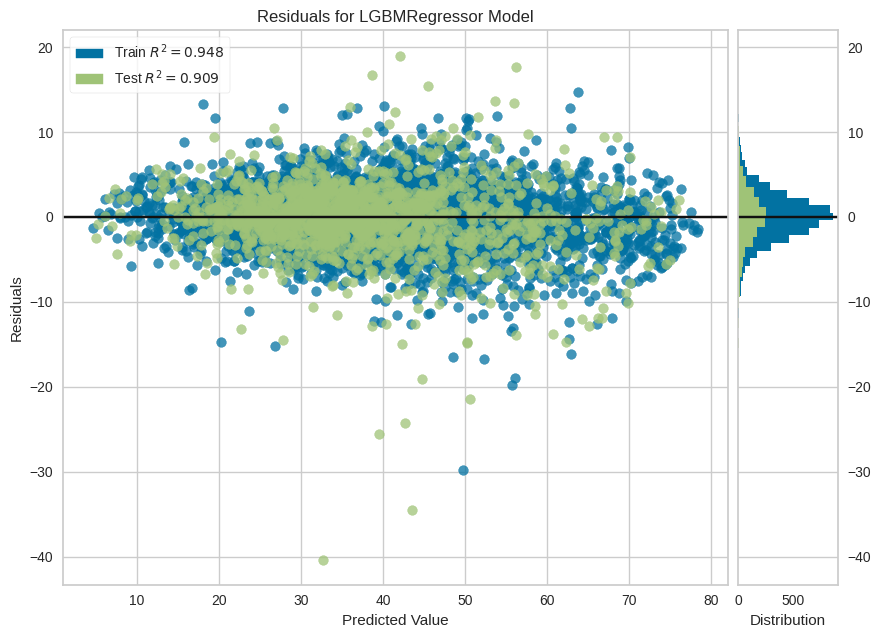

In [276]:
visualizer = RadViz(size=(1000, 720))
visualizer = ResidualsPlot(pipe_model)

visualizer.fit(X_train_s, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_s, y_test)  # Evaluate the model on the test data
visualizer.show();

In [280]:
results_df = pd.DataFrame({
    "actual": y_test,
    "predict": y_pred,
    "residuals": y_test - y_pred
})

In [289]:
results_df[results_df["residuals"]>20]

actual    predict  residuals
247   72.998  32.688213  40.309787
1042  77.992  43.538026  34.453974
1216  71.888  50.526459  21.361541
536   64.991  39.508593  25.482407
7529  66.999  42.696685  24.302315

## residual'ları fazla olanlara baktım fakat aralarında bir bağlantı bulamadım neden yanlış tahmin ettiğine dair belki o kategori de az ürün olduğundan olabilir

In [305]:
df1.loc[[247]]  #marka = ram

Used/New   Price  ConsumerReviews  SellerType  SellerRating  \
247         1  72.998               37           0           4.8   

     SellerReviews  DealType  Transmission_Type  weighted_consumer_rating  \
247              1         2                  0                     16.56   

     MPG  Litre  Count_of_model  Mileage_Year  dt_4WD  dt_AWD  dt_FWD  dt_RWD  \
247  450    3.6             112      2.308155       0       1       0       0   

     ft_Diesel  ft_Electric  ft_Flex Fuel  ft_Gasoline  ft_Hybrid  mk_Acura  \
247          0            0             0            1          0         0   

     mk_Audi  mk_BMW  mk_Buick  mk_Cadillac  mk_Chevrolet  mk_Dodge  mk_Ford  \
247        0       0         0            0             0         0        0   

     mk_GMC  mk_Honda  mk_Hyundai  mk_INFINITI  mk_Jeep  mk_Kia  mk_Land  \
247       0         0           0            0        0       0        0   

     mk_Lexus  mk_Lincoln  mk_Mazda  mk_Mercedes-Benz  mk_Nissan  mk_Other  \
247         0           0         0                 0          0         0   

     mk_Porsche  mk_RAM  mk_Subaru  mk_Tesla  mk_Toyota  mk_Volkswagen  \
247           1       0          0         0          0              0   

     mk_Volvo  ca_H4  ca_H6  ca_I3  ca_I4  ca_I5  ca_I6  ca_V10  ca_V6  ca_V8  \
247         0      0      1      0      0      0      0       0      0      0   

     ca_electric  sp_0  sp_1.0  sp_10.0  sp_2.0  sp_4.0  sp_5.0  sp_6.0  \
247            0     0       0        0       0       0       0       0   

     sp_7.0  sp_8.0  sp_9.0  st_AZ  st_CA  st_CO  st_FL  st_GA  st_IL  st_IN  \
247       1       0       0      0      1      0      0      0      0      0   

     st_MA  st_MD  st_MI  st_MN  st_MO  st_NC  st_NJ  st_NY  st_OH  st_Other  \
247      0      0      0      0      0      0      0      0      0         0   

     st_PA  st_SC  st_TN  st_TX  st_VA  st_WA  
247      0      0      0      0      0      0

In [304]:
df1.loc[[536]] #toyoto

Used/New   Price  ConsumerReviews  SellerType  SellerRating  \
536         1  64.991               28           0           4.7   

     SellerReviews  DealType  Transmission_Type  weighted_consumer_rating  \
536           1902         0                  1                    13.932   

      MPG  Litre  Count_of_model  Mileage_Year  dt_4WD  dt_AWD  dt_FWD  \
536  1296    2.5             711     -1.400529       0       0       1   

     dt_RWD  ft_Diesel  ft_Electric  ft_Flex Fuel  ft_Gasoline  ft_Hybrid  \
536       0          0            0             0            0          1   

     mk_Acura  mk_Audi  mk_BMW  mk_Buick  mk_Cadillac  mk_Chevrolet  mk_Dodge  \
536         0        0       0         0            0             0         0   

     mk_Ford  mk_GMC  mk_Honda  mk_Hyundai  mk_INFINITI  mk_Jeep  mk_Kia  \
536        0       0         0           0            0        0       0   

     mk_Land  mk_Lexus  mk_Lincoln  mk_Mazda  mk_Mercedes-Benz  mk_Nissan  \
536        0         0           0         0                 0          0   

     mk_Other  mk_Porsche  mk_RAM  mk_Subaru  mk_Tesla  mk_Toyota  \
536         0           0       0          0         0          1   

     mk_Volkswagen  mk_Volvo  ca_H4  ca_H6  ca_I3  ca_I4  ca_I5  ca_I6  \
536              0         0      0      0      0      1      0      0   

     ca_V10  ca_V6  ca_V8  ca_electric  sp_0  sp_1.0  sp_10.0  sp_2.0  sp_4.0  \
536       0      0      0            0     1       0        0       0       0   

     sp_5.0  sp_6.0  sp_7.0  sp_8.0  sp_9.0  st_AZ  st_CA  st_CO  st_FL  \
536       0       0       0       0       0      0      0      0      0   

     st_GA  st_IL  st_IN  st_MA  st_MD  st_MI  st_MN  st_MO  st_NC  st_NJ  \
536      0      0      0      0      0      0      0      0      0      0   

     st_NY  st_OH  st_Other  st_PA  st_SC  st_TN  st_TX  st_VA  st_WA  
536      0      0         0      0      0      0      1      0      0

In [306]:
df1.loc[[1216]] #land

Used/New   Price  ConsumerReviews  SellerType  SellerRating  \
1216         1  71.888               38           0           4.7   

      SellerReviews  DealType  Transmission_Type  weighted_consumer_rating  \
1216            148         1                  0                    16.574   

      MPG  Litre  Count_of_model  Mileage_Year  dt_4WD  dt_AWD  dt_FWD  \
1216  266    5.0             154      0.530561       1       0       0   

      dt_RWD  ft_Diesel  ft_Electric  ft_Flex Fuel  ft_Gasoline  ft_Hybrid  \
1216       0          0            0             0            1          0   

      mk_Acura  mk_Audi  mk_BMW  mk_Buick  mk_Cadillac  mk_Chevrolet  \
1216         0        0       0         0            0             0   

      mk_Dodge  mk_Ford  mk_GMC  mk_Honda  mk_Hyundai  mk_INFINITI  mk_Jeep  \
1216         0        0       0         0           0            0        0   

      mk_Kia  mk_Land  mk_Lexus  mk_Lincoln  mk_Mazda  mk_Mercedes-Benz  \
1216       0        1         0           0         0                 0   

      mk_Nissan  mk_Other  mk_Porsche  mk_RAM  mk_Subaru  mk_Tesla  mk_Toyota  \
1216          0         0           0       0          0         0          0   

      mk_Volkswagen  mk_Volvo  ca_H4  ca_H6  ca_I3  ca_I4  ca_I5  ca_I6  \
1216              0         0      0      0      0      0      0      0   

      ca_V10  ca_V6  ca_V8  ca_electric  sp_0  sp_1.0  sp_10.0  sp_2.0  \
1216       0      0      1            0     0       0        0       0   

      sp_4.0  sp_5.0  sp_6.0  sp_7.0  sp_8.0  sp_9.0  st_AZ  st_CA  st_CO  \
1216       0       0       0       0       1       0      0      0      0   

      st_FL  st_GA  st_IL  st_IN  st_MA  st_MD  st_MI  st_MN  st_MO  st_NC  \
1216      0      0      0      0      0      0      0      0      0      0   

      st_NJ  st_NY  st_OH  st_Other  st_PA  st_SC  st_TN  st_TX  st_VA  st_WA  
1216      0      0      0         0      0      0      0      0      1      0

In [307]:
df1.loc[[1042]] # nissan

Used/New   Price  ConsumerReviews  SellerType  SellerRating  \
1042         1  77.992                4           0           4.7   

      SellerReviews  DealType  Transmission_Type  weighted_consumer_rating  \
1042            722         0                  0                     17.22   

      MPG  Litre  Count_of_model  Mileage_Year  dt_4WD  dt_AWD  dt_FWD  \
1042  180    5.5             736      2.355327       0       1       0   

      dt_RWD  ft_Diesel  ft_Electric  ft_Flex Fuel  ft_Gasoline  ft_Hybrid  \
1042       0          0            0             0            1          0   

      mk_Acura  mk_Audi  mk_BMW  mk_Buick  mk_Cadillac  mk_Chevrolet  \
1042         0        0       0         0            0             0   

      mk_Dodge  mk_Ford  mk_GMC  mk_Honda  mk_Hyundai  mk_INFINITI  mk_Jeep  \
1042         0        0       0         0           0            0        0   

      mk_Kia  mk_Land  mk_Lexus  mk_Lincoln  mk_Mazda  mk_Mercedes-Benz  \
1042       0        0         0           0         0                 1   

      mk_Nissan  mk_Other  mk_Porsche  mk_RAM  mk_Subaru  mk_Tesla  mk_Toyota  \
1042          0         0           0       0          0         0          0   

      mk_Volkswagen  mk_Volvo  ca_H4  ca_H6  ca_I3  ca_I4  ca_I5  ca_I6  \
1042              0         0      0      0      0      0      0      0   

      ca_V10  ca_V6  ca_V8  ca_electric  sp_0  sp_1.0  sp_10.0  sp_2.0  \
1042       0      0      1            0     0       0        0       0   

      sp_4.0  sp_5.0  sp_6.0  sp_7.0  sp_8.0  sp_9.0  st_AZ  st_CA  st_CO  \
1042       0       0       0       1       0       0      0      0      0   

      st_FL  st_GA  st_IL  st_IN  st_MA  st_MD  st_MI  st_MN  st_MO  st_NC  \
1042      1      0      0      0      0      0      0      0      0      0   

      st_NJ  st_NY  st_OH  st_Other  st_PA  st_SC  st_TN  st_TX  st_VA  st_WA  
1042      0      0      0         0      0      0      0      0      0      0

In [308]:
df1.loc[[7529]]  #mk_Chevrolet

Used/New   Price  ConsumerReviews  SellerType  SellerRating  \
7529         1  66.999              157           0           4.0   

      SellerReviews  DealType  Transmission_Type  weighted_consumer_rating  \
7529             19         0                  0                    17.568   

      MPG  Litre  Count_of_model  Mileage_Year  dt_4WD  dt_AWD  dt_FWD  \
7529  416    0.0             380      -0.17983       0       0       0   

      dt_RWD  ft_Diesel  ft_Electric  ft_Flex Fuel  ft_Gasoline  ft_Hybrid  \
7529       1          0            0             0            1          0   

      mk_Acura  mk_Audi  mk_BMW  mk_Buick  mk_Cadillac  mk_Chevrolet  \
7529         0        0       0         0            0             1   

      mk_Dodge  mk_Ford  mk_GMC  mk_Honda  mk_Hyundai  mk_INFINITI  mk_Jeep  \
7529         0        0       0         0           0            0        0   

      mk_Kia  mk_Land  mk_Lexus  mk_Lincoln  mk_Mazda  mk_Mercedes-Benz  \
7529       0        0         0           0         0                 0   

      mk_Nissan  mk_Other  mk_Porsche  mk_RAM  mk_Subaru  mk_Tesla  mk_Toyota  \
7529          0         0           0       0          0         0          0   

      mk_Volkswagen  mk_Volvo  ca_H4  ca_H6  ca_I3  ca_I4  ca_I5  ca_I6  \
7529              0         0      0      0      0      0      0      0   

      ca_V10  ca_V6  ca_V8  ca_electric  sp_0  sp_1.0  sp_10.0  sp_2.0  \
7529       0      0      1            0     0       0        0       0   

      sp_4.0  sp_5.0  sp_6.0  sp_7.0  sp_8.0  sp_9.0  st_AZ  st_CA  st_CO  \
7529       0       0       0       0       1       0      1      0      0   

      st_FL  st_GA  st_IL  st_IN  st_MA  st_MD  st_MI  st_MN  st_MO  st_NC  \
7529      0      0      0      0      0      0      0      0      0      0   

      st_NJ  st_NY  st_OH  st_Other  st_PA  st_SC  st_TN  st_TX  st_VA  st_WA  
7529      0      0      0         0      0      0      0      0      0      0